### Initialization

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install implicit

Note: you may need to restart the kernel to use updated packages.


# Creating a Recommendation System

### Capstone - Smart Tourism
Thomas August Maria Stenger  <br>
Tamara Samaha  <br>
Manuel Hüpperich  <br>
Ignacio Gonzalez <br>
Daniel Chacon <br>
Alexander Humpert


# Table of Contents

[Baseline EDA](#1)
* [1. Importing Libraries](#1.1)
* [2. Data Cleaning & Preparation](#1.2)
* [3. Visualizations & Plotting Insights](#1.3)

[Baseline Models](#2)
* [1. Importing Libraries](#2.1)
* [2. Importing Data](#2.2)
* [3. Cleaning Data](#2.3)
* [4. Creating Train/Test Split](#2.4)
* [5. Creating Baseline Models](#2.5)
* [6. Comparing Initial Models](#2.6)
* [7. Hyperparameter Tuning](#2.7)
* [8. Ensemble Voting Regressor](#2.8)

[Matrix Factorization](#3)
* [1. Importing Libraries](#3.1)
* [2. Importing Data](#3.2)
* [3. Cleaning Data](#3.3)
* [4. Preparing Utility Matrix](#3.4)
* [5. EDA](#3.5)
* [6. Baseline ALS Matrix Factorization Model](#3.6)
* [7. SVD Matrix Facorization Model](#3.7)

<a id='1'></a>

# Baseline EDA

<a id='1.1'></a>

## 1. Importing Libraries

In [4]:
import calendar
import datetime as dt
import matplotlib.pyplot as plt
from pylab import *
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
%matplotlib inline

In [5]:
df = pd.read_csv("final_data_files/new_customer.csv")
# Importing buildings dataset
buildings = pd.read_csv("final_data_files/monuments_final_cleaned.csv")

<a id='1.2'></a>
## 2. Data Cleaning & Preparation

In [6]:
df.head()
df.shape

(525, 27)

In [7]:
# need to change column names for better understandability of the EDA process
column_names = ["id", "email","pub_date","name","surname","popular_places_foot", "popularity_places","pricey","green_spaces","scenic","pets","literature","casual","public_wifi","history","museums","street_perform","authentic_exp","sport","family-friendly","partner","click_on_link","dot_product","valuation", "opinion", "building_id", "username_id"]
df.columns = column_names
df.head()

,id,email,pub_date,name,surname,popular_places_foot,popularity_places,pricey,green_spaces,scenic,...,authentic_exp,sport,family-friendly,partner,click_on_link,dot_product,valuation,opinion,building_id,username_id
0,1,mahupperich@gmail.com,2022-06-23 11:22:00.321447+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,0,1,0,7,5,NaN,Estadio santiago bernabeu,manu3
1,2,mahupperich@gmail.com,2022-06-23 11:22:00.325125+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,0,1,0,6,5,NaN,Puerta del Sol,manu3
2,3,mahupperich@gmail.com,2022-06-23 11:22:00.32855+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,0,1,0,6,5,NaN,Parque del Retiro,manu3
3,4,mahupperich@gmail.com,2022-06-23 11:22:00.33203+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,0,1,0,5,5,NaN,Palacio Real,manu3
4,5,mahupperich@gmail.com,2022-06-23 11:22:00.335444+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,0,1,0,5,0,NaN,Plaza Mayor,manu3


In [8]:
df.describe()[:][0:3]

,id,popular_places_foot,popularity_places,pricey,green_spaces,scenic,pets,literature,casual,public_wifi,history,museums,street_perform,authentic_exp,sport,family-friendly,partner,click_on_link,dot_product,valuation
count,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.000000,525.0,525.000000,525.000000
mean,263.000000,0.523810,0.790476,0.647619,0.819048,0.733333,0.200000,0.523810,0.866667,0.380952,0.723810,0.723810,0.523810,0.876190,0.628571,0.390476,0.466667,0.0,6.567619,2.443810
std,151.698715,0.499909,0.407357,0.478167,0.385346,0.442638,0.400381,0.499909,0.340259,0.486084,0.447539,0.447539,0.499909,0.329678,0.483648,0.488322,0.499363,0.0,1.747872,2.177957


In [9]:
# mean valuation of 2.44 is surprising - we know that some people have forgotten to fill in the valuation feedback, ranging from 1-5 stars - let's see how many rows we have with 0 
# Valuation will be our target variable, so it is important to correctly handle this variable and decide whether we need to consider a 0 here as a NaN and clean for it

original_rows = len(df)
invalid_rows = len(df[(df.valuation == 0)])
manu = len(df[(df.valuation == 0) & (df.name == 'Manuel') & (df.surname == 'Hupperich')])

print(f"{invalid_rows} rows out of {original_rows} rows are missing a valid valuation - representing {round((invalid_rows/original_rows)*100,2)}% of the dataset.")
print(f"Easter egg - Our very own Manu is responsible for {manu} rows of invalid valuations - {round((manu/invalid_rows)*100,2)}% of all missing valuations.") 
print(f"This still leaves {invalid_rows - manu} potentially relevant rows with an invalid input for our target variable - {round(((invalid_rows-manu)/original_rows)*100,2)}% of the dataset.")

print("We can consider 0 to be equal to a NaN/Missing Value and will drop them consequently.")
df.drop(df.index[df["valuation"]==0],inplace=True)
print(f"We end up with {len(df)} rows with valid valuations.")

204 rows out of 525 rows are missing a valid valuation - representing 38.86% of the dataset.
Easter egg - Our very own Manu is responsible for 76 rows of invalid valuations - 37.25% of all missing valuations.
This still leaves 128 potentially relevant rows with an invalid input for our target variable - 24.38% of the dataset.
We can consider 0 to be equal to a NaN/Missing Value and will drop them consequently.
We end up with 321 rows with valid valuations.


In [10]:
# This cleaned data will be more informative for us in terms of understanding relationships of our features and our target variable and for further EDA
# A mean valuation of 3.99 with a standard deviation of 1.24 makes more sense 
df.describe()[:][0:3]

,id,popular_places_foot,popularity_places,pricey,green_spaces,scenic,pets,literature,casual,public_wifi,history,museums,street_perform,authentic_exp,sport,family-friendly,partner,click_on_link,dot_product,valuation
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.0,321.000000,321.000000
mean,229.348910,0.454829,0.819315,0.595016,0.884735,0.676012,0.140187,0.479751,0.906542,0.314642,0.753894,0.716511,0.473520,0.906542,0.548287,0.348910,0.495327,0.0,6.433022,3.996885
std,153.155098,0.498733,0.385358,0.491655,0.319840,0.468726,0.347723,0.500370,0.291528,0.465098,0.431413,0.451395,0.500078,0.291528,0.498440,0.477369,0.500759,0.0,1.780809,1.241215


In [11]:
# We can drop some irrelevant columns for our EDA: 

df.drop(columns=["id","email","name","surname","click_on_link"],inplace=True)
df.shape

(321, 22)

In [12]:
# Let's look at our users so far and what we can find out about them 
# The way we collect data and store it in our table means that we have at least 5 entries per person = 1 entry per recommendation/feedback, but with the same values for all questions answered
# Thus, we will drop any duplicate value under "username_id" (unique identifiers) to avoid unnecessarily inflating our user numbers and insights about them

unique_users_df = df.drop_duplicates(subset=['username_id'], keep='first')
print(f"{len(unique_users_df)} unique users in total.")

61 unique users in total.


In [13]:
# create list of questions/preferences to loop through later:
questions = ["popular_places_foot", "popularity_places","pricey","green_spaces","scenic","pets","literature","casual","public_wifi","history","museums","street_perform","authentic_exp","sport","family-friendly","partner"]

In [14]:
# creating a dataframe with the proportion of unique users that answered yes/no to each question/preference as a percentage: 
mean_questions = unique_users_df.describe()[:][1:2]

perc_dict = {}

for question in questions:
  perc_dict[question] = [round(mean_questions[question]["mean"]*100,2),round((1-mean_questions[question]["mean"])*100,2)]

tastes_df_perc = pd.DataFrame.from_dict(perc_dict)
tastes_df_perc.rename(index={0: 'Yes', 1: 'No'}, inplace=True)

<a id='1.3'></a>
## 3. Visualizations & Plotting Insights

### 3.1 Proportion of Users' Tastes/Preferences

In [15]:
tastes_df_perc

,popular_places_foot,popularity_places,pricey,green_spaces,scenic,pets,literature,casual,public_wifi,history,museums,street_perform,authentic_exp,sport,family-friendly,partner
Yes,45.9,83.61,60.66,88.52,68.85,9.84,49.18,93.44,29.51,77.05,70.49,49.18,93.44,54.1,34.43,49.18
No,54.1,16.39,39.34,11.48,31.15,90.16,50.82,6.56,70.49,22.95,29.51,50.82,6.56,45.9,65.57,50.82


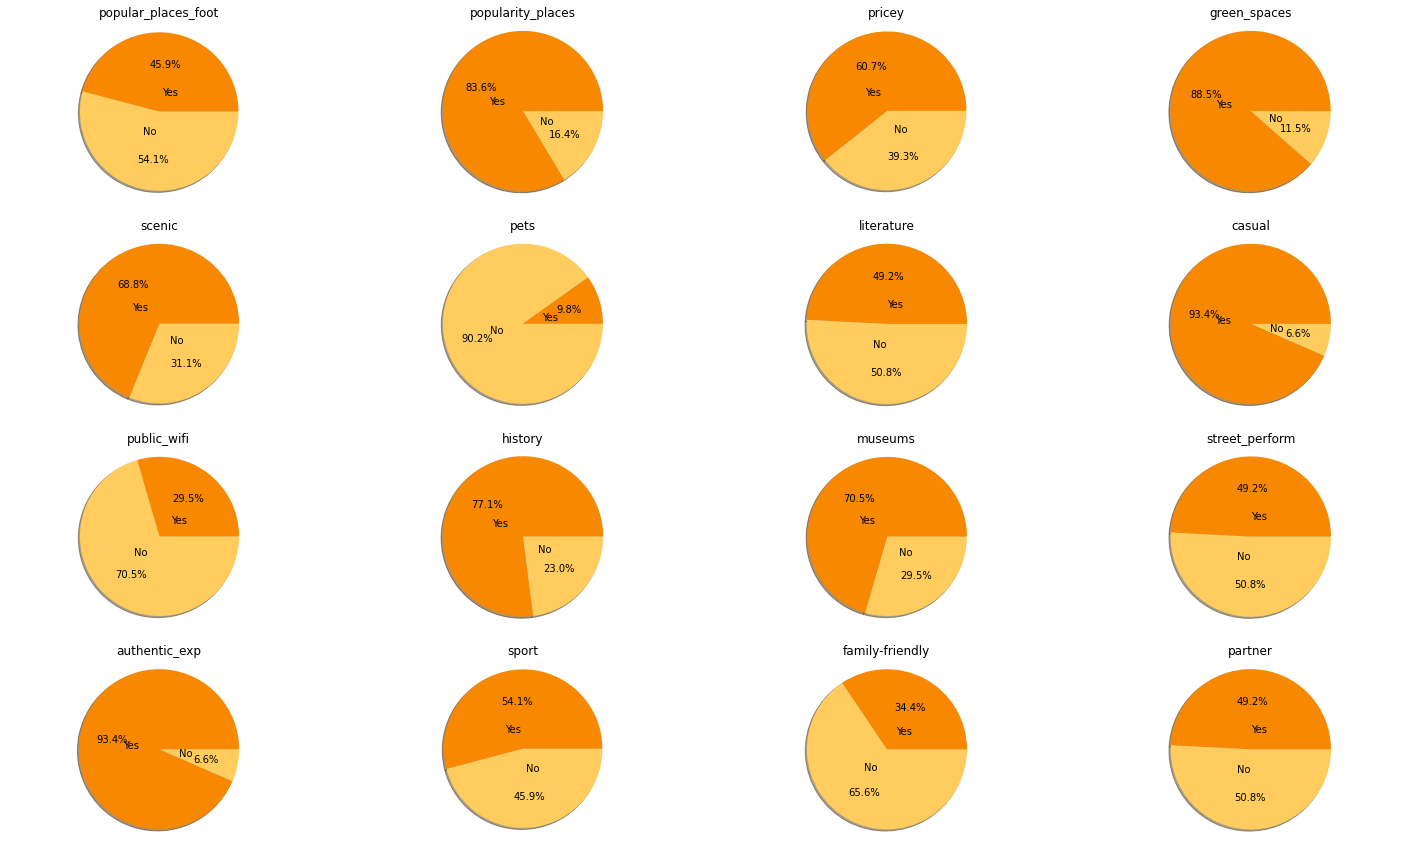

In [16]:
# plotting the tastes/preferences in bar plots to quickly identify potential insight:
# i.e. % of users willing to spend money on experiences; popular places foot vs. popularity places; authentic experiences; partner; etc.
fig, axes = plt.subplots(4,4, figsize=(25,15))

for ax,question in zip(axes.ravel(),questions):
    ax.pie(tastes_df_perc[question], labels=tastes_df_perc.index, autopct='%1.1f%%',
        shadow=True, startangle=0, colors=['#F88800','#FFCC5D'],
        rotatelabels=False, labeldistance=0.25)
    ax.set_title(question)
    #ax.set_xlabel("Prediction" , fontsize = 15)
    #ax.set_ylabel("Percentage %" , fontsize = 15)
    ax.axis('equal')

### 3.2 Total Recommendations Made per Location

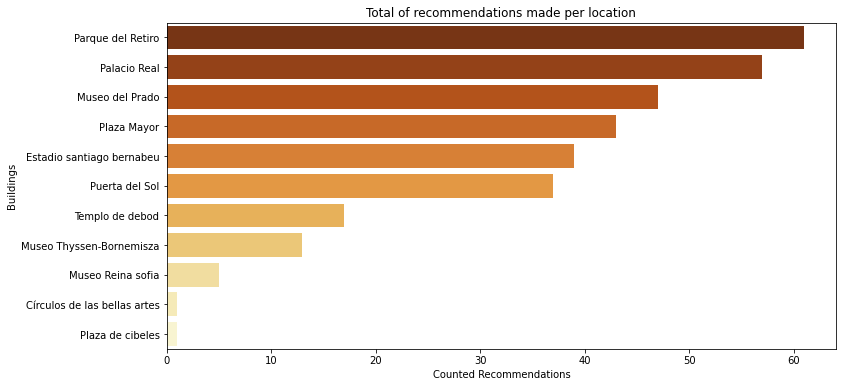

In [17]:
plt.figure(figsize=(12, 6))

# let's see how many times each location was recommended and plot it
locations_count_recs = df[["building_id","username_id"]]
locations_count_recs = pd.DataFrame(locations_count_recs.groupby("building_id").count())
locations_count_recs.columns = ["count_recommendations"]
locations_count_recs = locations_count_recs.sort_values(by='count_recommendations', ascending=False)

sns.barplot(x="count_recommendations", y=locations_count_recs.index, data=locations_count_recs, palette='YlOrBr_r').set(title="Total of recommendations made per location")
plt.xlabel('Counted Recommendations')
plt.ylabel('Buildings')
plt.show()

### 3.3 Location Ranking Valuation & Dot-product - Lolipop Graphs

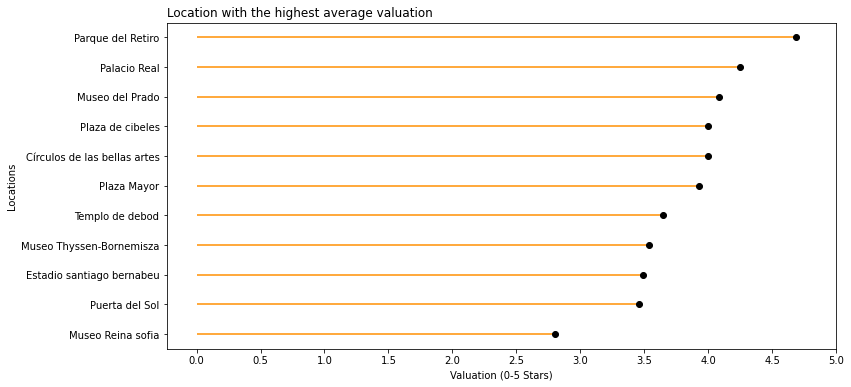

In [18]:
# Building with highest mean valuation 
locations_mean = df[["building_id","valuation",'dot_product']].groupby("building_id").mean()
# Reorder it based on the values
ordered_df = locations_mean.sort_values(by='valuation')
my_range=range(1,len(locations_mean.index)+1)
my_range_x = np.linspace(0,5,11, endpoint=True)

plt.figure(figsize=(12, 6))
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['valuation'], color='#FF8F00')
plt.plot(ordered_df['valuation'], my_range, "o", color='000000')
 
# Add titles and axis names
plt.yticks(my_range, ordered_df.index)
plt.xticks(my_range_x,my_range_x)
plt.title("Location with the highest average valuation", loc='left')
plt.xlabel('Valuation (0-5 Stars)')
plt.ylabel('Locations')

# Show the plot
plt.show()

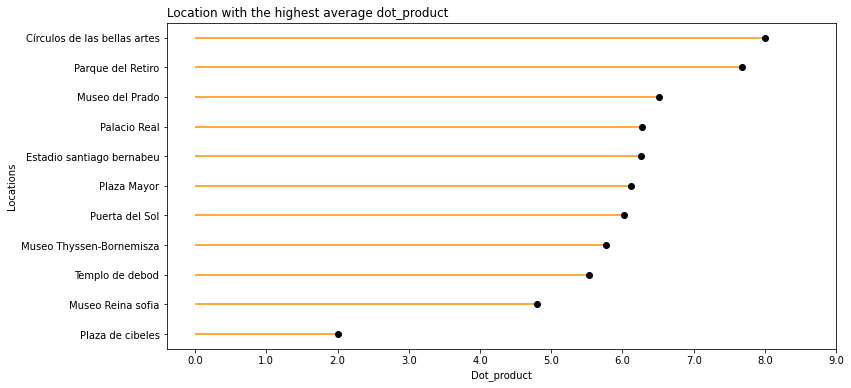

In [19]:
# Building with highest mean dot_product 
locations_mean = df[["building_id","valuation",'dot_product']].groupby("building_id").mean()
# Reorder it based on the values
ordered_df = locations_mean.sort_values(by='dot_product')
my_range=range(1,len(locations_mean.index)+1)
my_range_x = np.linspace(0,9,10, endpoint=True)


plt.figure(figsize=(12, 6))
# The horizontal plot is made using the hline function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['dot_product'], color='#FF8F00')
plt.plot(ordered_df['dot_product'], my_range, "o", color='000000')
 
# Add titles and axis names
plt.yticks(my_range, ordered_df.index)
plt.xticks(my_range_x,my_range_x)
plt.title("Location with the highest average dot_product", loc='left')
plt.xlabel('Dot_product')
plt.ylabel('Locations')

# Show the plot
plt.show()

### 3.4 Frequency Distribution Valuation & Dot-product - Histogram

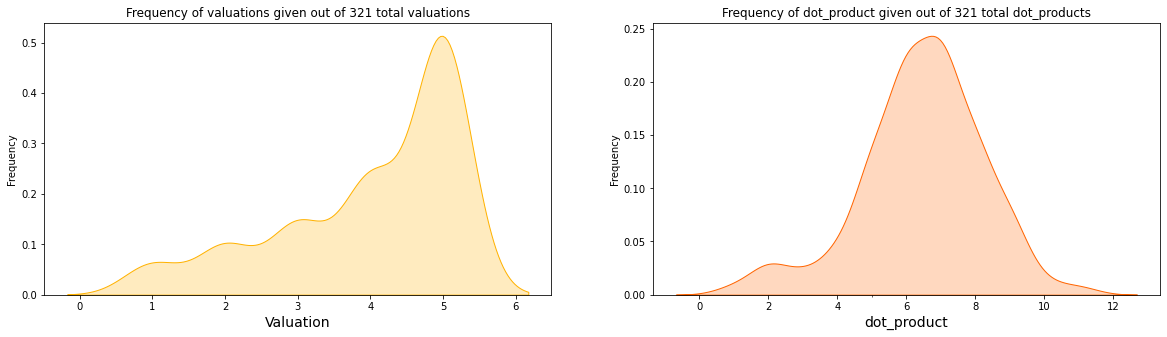

In [20]:
# histogram for dot_product & valuation
val_ran = (0,5)

fig, ax = plt.subplots(1,2,figsize=(20, 5))

# the histogram of the data 
sns.kdeplot(df["valuation"], shade=True, ax=ax[0], color='#FFB200') 

ax[0].set_xlabel('Valuation', fontsize=14)
ax[0].set_ylabel('Frequency', fontsize=10)
ax[0].set_xticks(val_ran, minor=True)

ax[0].set_title(f'Frequency of valuations given out of {len(df)} total valuations')

# 2
sns.kdeplot(df["dot_product"], shade=True, ax=ax[1], color='#FF6400') 

ax[1].set_xlabel('dot_product', fontsize=14)
ax[1].set_ylabel('Frequency', fontsize=10)
ax[1].set_xticks(val_ran, minor=True)

ax[1].set_title(f'Frequency of dot_product given out of {len(df)} total dot_products')

plt.show()

### 3.5 Relationship Valuation & Dot-product - Line Chart

<Figure size 864x432 with 0 Axes>

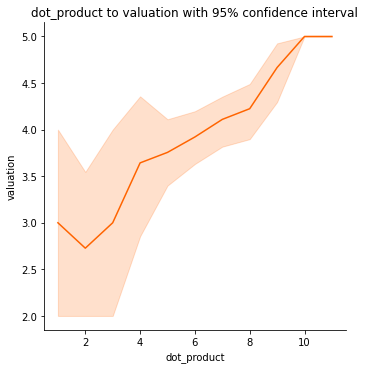

In [21]:
# line chart dot_product to valuation with 95% confidence interval 
# one potential insight allows to see around which thresholds the relationship exposes more/less variance to see if correlates or not
plt.figure(figsize=(12, 6))

sns.relplot(data=df, x="dot_product", y="valuation", kind="line", color='#FF6400').set(title="dot_product to valuation with 95% confidence interval")

plt.show()

<a id='2'></a>
# Baseline Models

<a id='2.2'></a>
## 1. Importing Libraries

In [22]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve

<a id='2.2'></a>

## 2. Importing Data

In [23]:
df_answers = pd.read_csv("final_data_files/polls_customer.csv")
df_answers.head(2)

,id,email,pub_date,name,surname,question_text1,question_text2,question_text3,question_text4,question_text5,...,question_text13,question_text14,question_text15,question_text16,click_on_link,dot_product,valuation,opinion,building_id,username_id
0,1,mahupperich@gmail.com,2022-06-23 11:22:00.321447+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,0,1,0,7,5,NaN,Estadio santiago bernabeu,manu3
1,2,mahupperich@gmail.com,2022-06-23 11:22:00.325125+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,0,1,0,6,5,NaN,Puerta del Sol,manu3


In [24]:
df_locations = pd.read_csv("final_data_files/monuments_final_cleaned.csv")
df_locations.head(2)

,Unnamed: 0,name,longitude,latitude,q1,q2,q3,q4,q5,q6,...,q9,q10,q11,q12,q13,q14,q15,q16,desc,link
0,0,Palacio Real,-3.714258,40.418056,1,1,0,1,1,0,...,0,1,0,1,0,1,0,1,The Royal Palace of Madrid is the largest in W...,https://www.disfrutamadrid.com/palacio-real
1,1,Puerta del Sol,-3.703305,40.416968,1,0,0,1,0,0,...,0,1,1,0,0,1,1,1,Puerta del Sol (meaning The Sun's Gate in Engl...,https://www.disfrutamadrid.com/puerta-del-sol


<a id='2.3'></a>

## 3. Cleaning Data

In [25]:
df_answers_clean = df_answers[df_answers["valuation"]!=0]
df_locations_clean = df_locations.drop(['Unnamed: 0', 'longitude', 'latitude', 'desc', 'link'], axis=1)
df_combined = df_answers_clean.merge(df_locations_clean, left_on='building_id', right_on='name')
df_combined

,id,email,pub_date,name_x,surname,question_text1,question_text2,question_text3,question_text4,question_text5,...,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16
0,1,mahupperich@gmail.com,2022-06-23 11:22:00.321447+02,Manuel,Hupperich,1,0,1,1,0,...,1,1,1,1,0,0,1,1,0,0
1,17,thomas.stenger@student.ie.edu,2022-06-23 11:35:13.718045+02,Thomas,Stenger,0,1,1,1,1,...,1,1,1,1,0,0,1,1,0,0
2,25,ignaciogonzalez@student.ie.edu,2022-06-23 11:42:53.187427+02,Ignacio,Gonzalez Granero,1,1,0,1,0,...,1,1,1,1,0,0,1,1,0,0
3,31,martina.cilia@student.ie.edu,2022-06-23 18:48:42.545531+02,Martina,Cilia,0,1,0,1,1,...,1,1,1,1,0,0,1,1,0,0
4,41,michaelastenger@hotmail.de,2022-06-24 11:41:13.065589+02,Michaela,Stenger,1,1,0,1,1,...,1,1,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,318,mahupperich@gmail.com,2022-06-29 08:27:40.483544+02,Manuel,Hupperich,1,1,0,1,1,...,1,0,0,1,1,1,0,0,0,1
402,451,tamarasamaha@student.ie.edu,2022-06-30 17:24:20.219199+02,Tamara,Samaha,0,1,0,0,0,...,0,1,0,1,1,0,0,0,1,0
403,560,gordillotorresjordi@gmail.com,2022-07-01 21:37:40.068227+02,Jordi,Gordillo,0,1,1,1,0,...,0,1,0,1,1,0,0,0,1,0
404,603,mahupperich@gmail.com,2022-07-06 09:17:41.591222+02,Manuel,Hupperich,1,1,0,1,0,...,0,1,0,1,1,0,0,0,1,0


In [26]:
# Defining conditions for incorrectly answered questionnaires

maximum = 16
minimum = 0

# Filtering dataframe
questionnaire = df_answers.loc[:, "question_text1":"question_text16"]

# Adding answer_sum column
questionnaire["answer_sum"] = questionnaire.sum(axis = 1)

# Adding column identifying whether user answers correctly or not
questionnaire["not_correct"] = np.where(questionnaire["answer_sum"] == maximum | minimum, 
                                       1, 
                                       0)

# Number of users who incorrectly answered questionnaire
incorrect_questionnaire = questionnaire[questionnaire["not_correct"] == 0 | 1]
incorrect_users = len(incorrect_questionnaire)/5
# Count of no feedback
no_feedback= len(df_answers[df_answers["valuation"] == 0])

bad_users = len(df_answers[df_answers["valuation"] == 0]["username_id"].value_counts())
# Creating dataframe of only duplicates
duplicates = df_answers[df_answers.duplicated(['username_id', "building_id"])]

# Removing the first appearance of duplicates rows
singles_from_duplicates = duplicates.drop_duplicates(subset=["username_id", "building_id"], keep='first')

# Calculating remaining 
num_duplicates_removed = len(duplicates) - len(singles_from_duplicates)
num_duplicates = len(duplicates)









### Removing Rows

In [27]:
ratings = df_answers.copy()

In [28]:
users = len(ratings["username_id"].value_counts())

print(f"The initial number of observations is {len(ratings)}")
print(f"The initial number of users is {users}")

The initial number of observations is 625
The initial number of users is 91


In [29]:
# Adding "Not correct" column to ratings dataframe
ratings["not_correct"] = questionnaire["not_correct"]

# Dropping rows with incorrectly answered questionnaires
ratings.drop(ratings[ratings["not_correct"] == 0 | 1].index, inplace = True)

# Recalculating number of users
users = len(ratings["username_id"].value_counts())

In [30]:
print("After dropping observations with incorrectly completed questionnaires:")
print(f"The remaining number of observations is {len(ratings)}")
print(f"The remaining number of users is {users}")

After dropping observations with incorrectly completed questionnaires:
The remaining number of observations is 610
The remaining number of users is 91


Dropping observations with no feedback

In [31]:
# Dropping rows with no feedback
ratings.drop(ratings[ratings["valuation"] == 0].index, inplace = True)

# Recalculating number of users
users = len(ratings["username_id"].value_counts())

In [32]:
print("After dropping observations who did not provide feedback:")
print(f"The remaining number of observations is {len(ratings)}")
print(f"The remaining number of users is {users}")

After dropping observations who did not provide feedback:
The remaining number of observations is 405
The remaining number of users is 76


Dropping observations with duplicate username and item_ids

In [33]:
# Dropping all rows where a user rated a building twice

ratings = ratings.drop_duplicates(subset=["username_id", "building_id"], keep='first')

# Recalculating number of users
users = len(ratings["username_id"].value_counts())

In [34]:
print("After dropping observations who rated buildings twice:")
print(f"The remaining number of observations is {len(ratings)}")
print(f"The remaining number of users is {users}")

After dropping observations who rated buildings twice:
The remaining number of observations is 387
The remaining number of users is 76


<a id='2.4'></a>

## 4. Creating Train/Test

In [35]:
y = df_combined[['valuation']]
x = df_combined.drop(['valuation', 'id', 'email', 'pub_date', 'name_x', 'surname', 'dot_product', 'opinion', 'building_id', 'username_id', 'click_on_link', 'name_y'], axis=1)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

<a id='2.5'></a>

## 5. Creating Baseline Models

In [37]:
# Dictionary structure for comp. table - taken from Python II project (Thomas):
## need to implement a preprocessor / pipeline before this to be able to fit and predict data
### final steps - use gridsearch CV / randomsearch 

reg_dict = {
    "LinReg": {
        "algorithm": LinearRegression(),
        },
    "Lasso": {
        "algorithm": Lasso(),
    },
    "RandomForest": {
        "algorithm": RandomForestRegressor(random_state=7),
    },
    "LogisticRegression": {
        "algorithm": LogisticRegression(),
    },
    "SVR_poly": {
        "algorithm": SVR(kernel="poly"),
    },
    "SVR_rbf": {
        "algorithm": SVR(kernel="rbf"),
    },
    "KNN": {
        "algorithm": KNeighborsRegressor(),
    },
    "GradientBoosting": {
        "algorithm": GradientBoostingRegressor(random_state=7),
    }
}

for algo, algo_dict in reg_dict.items():
    reg = algo_dict["algorithm"].fit(x_train, y_train)
    algo_dict["train_predictions"] = reg.predict(x_train)
    algo_dict["train_r2_score"] = r2_score(y_train, algo_dict["train_predictions"])
    algo_dict["predictions"] = reg.predict(x_test)
    algo_dict["mse"] = mean_squared_error(y_test, algo_dict["predictions"])
    algo_dict["r2_score"] = r2_score(y_test, algo_dict["predictions"])
    algo_dict["rmse"] = mean_squared_error(y_test, algo_dict["predictions"], squared = False)

In [38]:
user_ratings = ratings.copy()
buildings = buildings.copy()

rating_svd = ratings
buildings_svd = buildings

In [39]:
user_ratings.drop(user_ratings[user_ratings["valuation"] == 0].index, inplace = True)
user_ratings = user_ratings.drop_duplicates(subset=["username_id", "building_id"], keep='first')

### What do users think of our app

In [40]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

In [41]:
def print_wordCloud(df, title):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in df.opinion:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1200, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10,
                    colormap='YlOrBr_r').generate(comment_words)

    # plot the WordCloud image                      
    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(title, fontsize=25, pad = 15)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

In [42]:
# Dataframe of only user comments
comments = pd.DataFrame(df_answers["opinion"])

# Dropping "no opinions"
comments.replace(to_replace ="No Opinion",
                 value = np.nan, inplace = True)

# Dropping Nulls
comments.dropna(inplace = True)

In [43]:
print(f"{len(comments)/5} users left comments.")

28.0 users left comments.


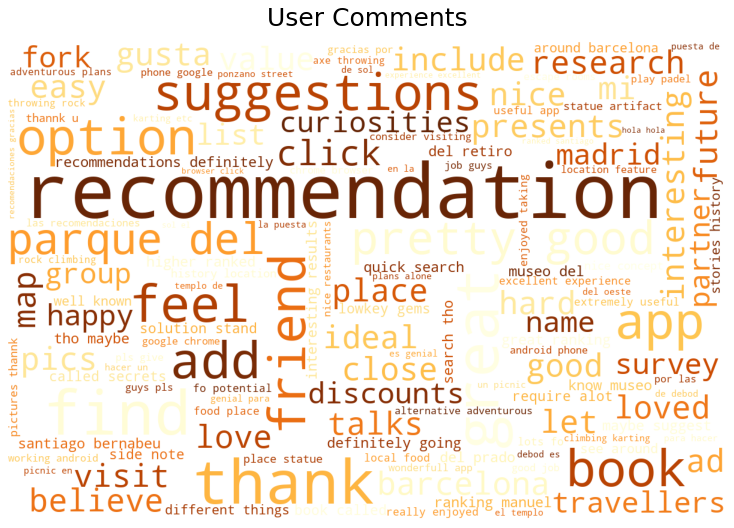

In [44]:
# Visualizing wordcloud of text labeled true
print_wordCloud(comments, 'User Comments')

In [45]:
# Computing TextBlob (rule-based) polarity score on user comments
comments["polarity"] = comments["opinion"].apply(lambda x:TextBlob(x).sentiment.polarity)

In [46]:
# Creating a dataframe of comments with only positive sentiment
comments_positive = comments[comments['polarity'] > 0][['opinion', "polarity"]]

# Creating a dataframe of comments with only negative sentiment
comments_negative = comments[comments['polarity'] < 0][['opinion', "polarity"]]

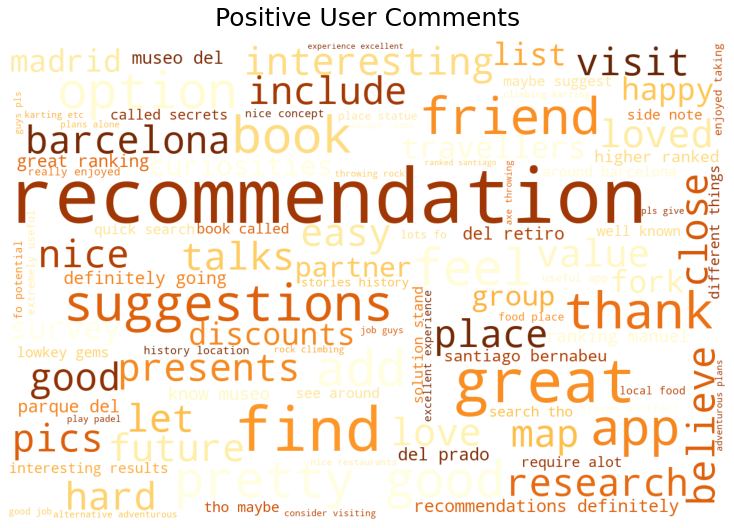

In [47]:
# Visualizing wordcloud of text labeled true
print_wordCloud(comments_positive, 'Positive User Comments')

<a id='2.6'></a>

## 6. Comparing Initial Models

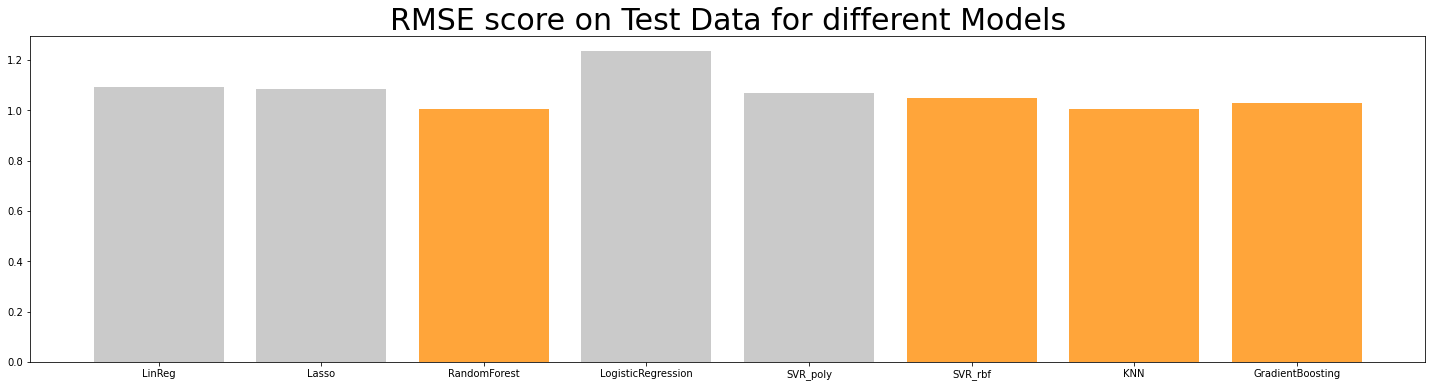

In [48]:
fig, ax = plt.subplots(figsize = (25,6))
selected_algos = ['RandomForest', 'SVR_rbf', 'KNN', 'GradientBoosting']

for algo, algo_dict in reg_dict.items():
    if algo in selected_algos:
        colr = '#FFA53A'
    else:
        colr = '#CACACA'
    ax.bar(algo, algo_dict["rmse"], label = algo, color=colr)
    ax.legend
    ax.set_title("RMSE score on Test Data for different Models", size=30)

In [49]:
for algo, algo_dict in reg_dict.items():
  print(f"{algo} : {round(reg_dict[algo]['rmse'], 3)}")

LinReg : 1.094
Lasso : 1.083
RandomForest : 1.003
LogisticRegression : 1.235
SVR_poly : 1.067
SVR_rbf : 1.048
KNN : 1.005
GradientBoosting : 1.027


<a id='2.7'></a>

## 7. Hyperparameter Tuning

### 7.1 Gradient Boosting Regressor

In [50]:
max_features = np.arange(0.3, 0.8, 0.1)
n_estimators = range(0, 100, 10)

param_grid_gb = {'max_features': max_features,
                'n_estimators': n_estimators,
                }

In [51]:
grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=7),
                           param_grid = param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_search_gb.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=7),
             param_grid={'max_features': array([0.3, 0.4, 0.5, 0.6, 0.7]),
                         'n_estimators': range(0, 100, 10)},
             scoring='neg_mean_squared_error')

In [52]:
best_gb = grid_search_gb.best_estimator_
best_gb.fit(x_train, y_train)

GradientBoostingRegressor(max_features=0.7000000000000002, n_estimators=40,
                          random_state=7)

In [53]:
gs_gb_predictions = best_gb.predict(x_test)
gs_gb_rmse = mean_squared_error(y_test, gs_gb_predictions, squared = False)
gb_baseline_rmse = reg_dict["GradientBoosting"]["rmse"]

print(f"""Baseline RMSE Score: {round(gb_baseline_rmse, 3)}
Tuned RMSE Score: {round(gs_gb_rmse, 3)}
Improvement: {round(round(gb_baseline_rmse, 3) - round(gs_gb_rmse, 3), 3)}""")

Baseline RMSE Score: 1.027
Tuned RMSE Score: 1.024
Improvement: 0.003


### 7.2 SVR

In [54]:
C = np.arange(0, 50, 5)
gamma = ['auto', 'scale']
epsilon = np.arange(0.2, 1, 0.2)
tol = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

param_grid_svr = {'C': C,
              'gamma': gamma,
              'epsilon': epsilon,
                 'tol': tol}

In [55]:
grid_search_svr = GridSearchCV(SVR(kernel='rbf'), param_grid = param_grid_svr, scoring='neg_mean_squared_error', cv=5)
grid_search_svr.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45]),
                         'epsilon': array([0.2, 0.4, 0.6, 0.8]),
                         'gamma': ['auto', 'scale'],
                         'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [56]:
best_svr = grid_search_svr.best_estimator_
best_svr

SVR(C=5, epsilon=0.4, tol=1e-05)

In [57]:
best_svr.fit(x_train, y_train)
predictions_svr = best_svr.predict(x_test)
gs_svr_rmse = (mean_squared_error(y_test, predictions_svr))**0.5
svr_baseline_mse = reg_dict["SVR_rbf"]["rmse"]

print(f"""Baseline RMSE Score: {round(svr_baseline_mse, 3)}
Tuned RMSE Score: {round(gs_svr_rmse, 3)}
Improvement: {round(round(svr_baseline_mse, 3) - round(gs_svr_rmse, 3), 3)}""")

Baseline RMSE Score: 1.048
Tuned RMSE Score: 1.029
Improvement: 0.019


### 7.3 KNN Regressor

In [58]:
n_neighbors = [2,3,4,5,6]
weights = ['uniform', 'distance']

param_grid_knn = {'n_neighbors': n_neighbors, 
                 'weights': weights}

In [59]:
grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid = param_grid_knn, scoring='neg_mean_squared_error', cv=5)
grid_search_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [60]:
best_knn = grid_search_knn.best_estimator_
best_knn

KNeighborsRegressor(n_neighbors=6, weights='distance')

In [61]:
best_knn.fit(x_train, y_train)
predictions_knn = best_knn.predict(x_test)
gs_knn_rmse = (mean_squared_error(y_test, predictions_knn))**0.5
knn_baseline_mse = reg_dict["RandomForest"]["rmse"]

print(f"""Baseline RMSE Score: {round(knn_baseline_mse, 3)}
Tuned RMSE Score: {round(gs_knn_rmse, 3)}
Improvement: {round(round(knn_baseline_mse, 3) - round(gs_knn_rmse, 3), 3)}""")

Baseline RMSE Score: 1.003
Tuned RMSE Score: 0.997
Improvement: 0.006


<a id='2.8'></a>

## 8. Ensemble Voting Regressor

In [62]:
model1 = best_svr
model2 = best_gb
model3 = best_knn
model4 = RandomForestRegressor(random_state=7)

voting = VotingRegressor(estimators=[('svr', model1), ('gb', model2), ('knn', model3), ('rf', model4)], n_jobs=-1)
voting.fit(x_train, y_train)

VotingRegressor(estimators=[('svr', SVR(C=5, epsilon=0.4, tol=1e-05)),
                            ('gb',
                             GradientBoostingRegressor(max_features=0.7000000000000002,
                                                       n_estimators=40,
                                                       random_state=7)),
                            ('knn',
                             KNeighborsRegressor(n_neighbors=6,
                                                 weights='distance')),
                            ('rf', RandomForestRegressor(random_state=7))],
                n_jobs=-1)

In [63]:
voting_predictions = voting.predict(x_test)
voting_mse = mean_squared_error(y_test, voting_predictions)
print(f"RMSE score for Voting Model: {round(voting_mse**0.5,3)}")

RMSE score for Voting Model: 0.988


In [64]:
best_rf = RandomForestRegressor(random_state=7)
best_rf.fit(x_train, y_train)

RandomForestRegressor(random_state=7)

In [65]:
def to_array(test):
  ls = []
  if str(type(test[0])) != "<class 'numpy.ndarray'>":
    return test
  else:
    for array in test:
      ls.append(array[0])
    return np.array(ls)

In [66]:
def plot_results(model_list, x_test, y_test, fig_size):
    fig, ax = plt.subplots(figsize=fig_size)
    results_df = pd.DataFrame(columns=['Index', 'Model', 'Result'])
    index_ls = []
    model_ls = []
    result_ls=[]
    
    for model in model_list:
        target_test_pred = to_array(model[1].predict(x_test))
        i = 0
        for value in target_test_pred:
            model_ls.append(model[0])
            result_ls.append(value)
            index_ls.append(i)
            i+=1
        i = 0
    for value in y_test['valuation']:
            model_ls.append('Real Values')
            result_ls.append(value)
            index_ls.append(i)
            i+=1
    
    results_df['Index'] = index_ls
    results_df['Models'] = model_ls
    results_df['Result'] = result_ls
    
    sns.set(font_scale=1.5)
    ax = sns.lineplot(x = 'Index', y = 'Result', data = results_df, hue = 'Models')
    ax.set(title = f"Model Predictions vs. Real Values", xlabel=None)
    ax.tick_params(bottom=False)
    plt.show()

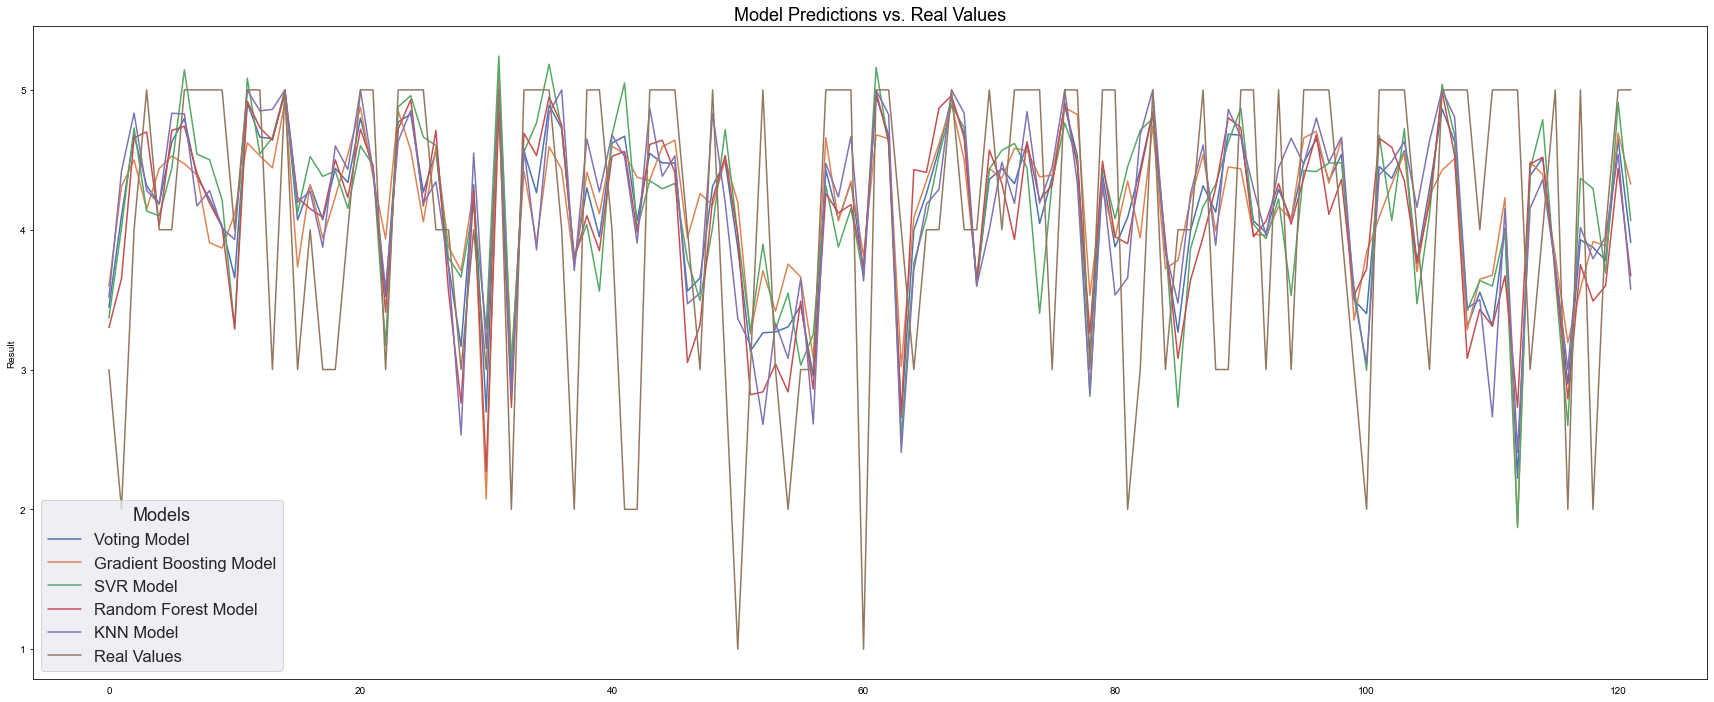

In [67]:
model_list = [['Voting Model', voting], ['Gradient Boosting Model', best_gb], ['SVR Model', best_svr], ['Random Forest Model', best_rf], ['KNN Model', best_knn]]

plot_results(model_list, x_test, y_test, fig_size = (30, 12))

<a id='3'></a>

# Matrix Factorization

<a id='3.1'></a>

## 1. Importing Libraries

In [5]:
# imports
import pandas as pd
import numpy as np
from fuzzywuzzy import process
from sklearn import preprocessing
from numpy.linalg import svd
from scipy.sparse import csr_matrix
import implicit


import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


<a id='3.2'></a>

## 2. Importing Data

In [8]:
# Importing buildings dataset
buildings = pd.read_csv("monuments_final_cleaned.csv")

# Importing ratings dataset
ratings = pd.read_csv("polls_customer_08072022.csv")

In [9]:
# Filtering buildings dataset
buildings.rename(columns = {'Unnamed: 0':'building_id'}, inplace = True)
buildings = buildings[["building_id", "name"]]
buildings.head()

,building_id,name
0,0,Palacio Real
1,1,Puerta del Sol
2,2,Plaza Mayor
3,3,Templo de debod
4,4,Estadio santiago bernabeu


In [10]:
# Filtering ratings dataset
ratings = ratings[["username_id", "building_id", "valuation"]]
ratings.head()

,username_id,building_id,valuation
0,manu3,Estadio santiago bernabeu,5
1,manu3,Puerta del Sol,5
2,manu3,Parque del Retiro,5
3,manu3,Palacio Real,5
4,manu3,Plaza Mayor,0


Creating copy of "ratings" and "buildings" dataframes before further manipulation.

In [11]:
user_ratings = ratings.copy()
buildings = buildings.copy()

rating_svd = ratings
buildings_svd = buildings

<a id='3.3'></a>

## 3. Cleaning Data

Each record in our "ratings" dataset is an explicity user rating, from 1 to 5 of a building recommendation. Our dataset must be cleaned before we can implement matrix factorization: 
1. Eliminate observations with a valuation of 0 - this means users failed to provide feedback on our initial recommendation.
2. Eliminate duplicate valuations - on user evaluating an item recommendation more than once.


### 3.1 Summary statistics

#### Unique number of users

In [12]:
#Total observations
initial_observations = len(ratings)

# Unique number of uses
unique_uses = len(ratings)/5

# Unique users
initial_unique_users = len(ratings["username_id"].value_counts())

print(f"We have a total of {initial_unique_users} unique users.")
print(f"We have a total of {initial_observations} observations.")
print(f"The web app was used a total of {unique_uses} times.")


We have a total of 91 unique users.
We have a total of 625 observations.
The web app was used a total of 125.0 times.


#### Unique sessions per users

4 users used the web app more than one time.
121.0 users used the web app only once.


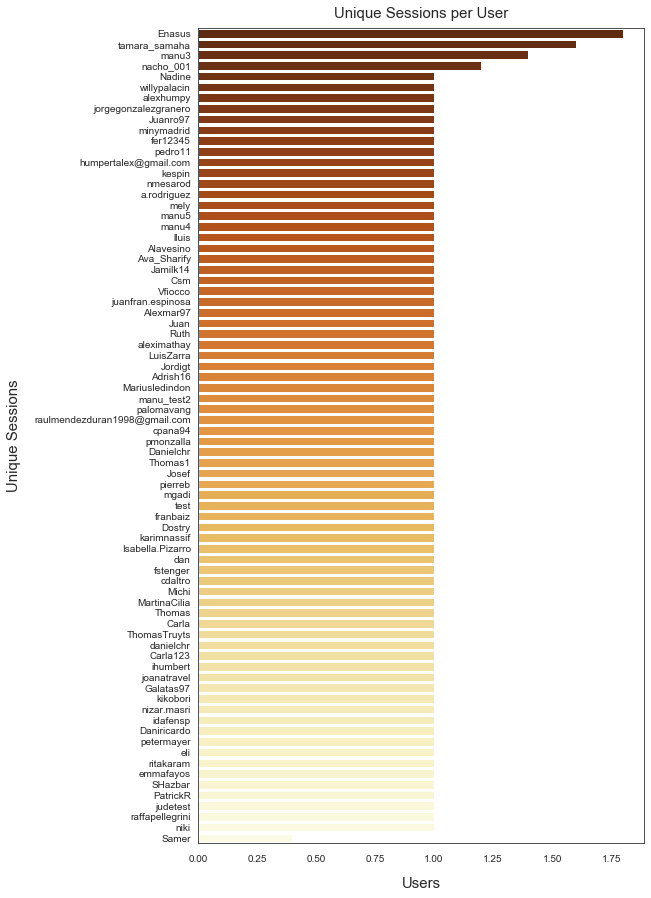

In [19]:
# Counting how often a user appears in dataset
user_appearances = pd.DataFrame(ratings["username_id"].value_counts())

# Saving user appearances to a list
users = list(user_appearances.index)

# Adding name of users as a column
user_appearances["users"] = users
user_appearances.rename(columns = {"username_id":"count"}, inplace = True)

# Calculating number of times each user used the app
user_appearances["unique_uses"] = user_appearances["count"]/5

# Filtering dataframe by number unique uses over 1 
more_than_once = len(user_appearances[user_appearances["unique_uses"] > 1.0])
only_once = unique_uses - more_than_once

print(f"{more_than_once} users used the web app more than one time.")
print(f"{only_once} users used the web app only once.")

# Graphing total distribution of unique uses
fig_dims = (8, 15)
sns.set_style(style='white')

fig, ax = plt.subplots(figsize=fig_dims)

# Plotting Graph
ax = sns.barplot(x = "unique_uses", y = "users", data = user_appearances, palette='YlOrBr_r')
ax.tick_params(axis='x', size=8)

# Annotating Graph
plt.title("Unique Sessions per User", size = 15, pad = 10)
plt.ylabel("Unique Sessions", size = 15, labelpad = 13)
plt.xlabel("Users", size = 15, labelpad = 13)
plt.show()

#### Measuring no feedback

In [20]:
# Count of no feedback
no_feedback= len(ratings[ratings["valuation"] == 0])

bad_users = len(ratings[ratings["valuation"] == 0]["username_id"].value_counts())


print(f"Out of the 500 recommendations, no feedback was provided on {no_feedback} of them.")
print(f"{bad_users} unique users did not provide feedback. Our feedback ratio is {1 - round((bad_users/unique_uses),2)}")

Out of the 500 recommendations, no feedback was provided on 0 of them.
0 unique users did not provide feedback. Our feedback ratio is 1.0


In [21]:
# Dropping rows with no feedback
ratings.drop(ratings[ratings["valuation"] == 0].index, inplace = True)

# Unique users
remaining_unique_users = len(ratings["username_id"].value_counts())

# Remaining observations
remaining_observations = len(ratings)

print(f"After dropping observations with no feedback, we have a total of {remaining_unique_users} remaining unique users.")
print(f"After dropping observations with no feedback, we are left with {remaining_observations} observations.")


After dropping observations with no feedback, we have a total of 76 remaining unique users.
After dropping observations with no feedback, we are left with 387 observations.


#### Dealing with duplicate uses

In [16]:
# Dropping all rows where a user rated a building twice

ratings = ratings.drop_duplicates(subset=["username_id", "building_id"], keep='first')

In [17]:
# Unique users
remaining_unique_users = len(ratings["username_id"].value_counts())

# Remaining observations
remaining_observations = len(ratings)

print(f"After dropping user-building duplicates, we have a total of {remaining_unique_users} remaining unique users.")
print(f"After dropping user-building duplicates, we are left with {remaining_observations}.")


After dropping user-building duplicates, we have a total of 76 remaining unique users.
After dropping user-building duplicates, we are left with 387.


<a id='3.4'></a>

## 4. Preparing Utility Matrix

#### 4.1 Replacing usernames with unique integer IDs.

Dictionary mapping usernames (keys) to zero based index ids (values).





In [79]:
# Counting unique users
users = ratings['username_id'].nunique()

# Creating list of range of unique users
users_index = list(range(users))

# Creating dictionary zipping each username to a unique index value
user_title_mapper = dict(zip(rating_svd['username_id'].unique(), users_index))

# Inspecting dictionary
user_title_mapper

{'manu3': 0,
 'Danielchr': 1,
 'Carla': 2,
 'Thomas': 3,
 'nacho_001': 4,
 'MartinaCilia': 5,
 'Michi': 6,
 'cdaltro': 7,
 'fstenger': 8,
 'dan': 9,
 'Isabella.Pizarro': 10,
 'karimnassif': 11,
 'Dostry': 12,
 'franbaiz': 13,
 'test': 14,
 'mgadi': 15,
 'pierreb': 16,
 'Josef': 17,
 'ThomasTruyts': 18,
 'tamara_samaha': 19,
 'Thomas1': 20,
 'danielchr': 21,
 'ihumbert': 22,
 'raffapellegrini': 23,
 'judetest': 24,
 'PatrickR': 25,
 'SHazbar': 26,
 'emmafayos': 27,
 'ritakaram': 28,
 'eli': 29,
 'petermayer': 30,
 'Daniricardo': 31,
 'idafensp': 32,
 'nizar.masri': 33,
 'kikobori': 34,
 'Galatas97': 35,
 'joanatravel': 36,
 'Carla123': 37,
 'pmonzalla': 38,
 'Jamilk14': 39,
 'cpana94': 40,
 'lluis': 41,
 'manu4': 42,
 'manu5': 43,
 'mely': 44,
 'a.rodriguez': 45,
 'nmesarod': 46,
 'kespin': 47,
 'Alavesino': 48,
 'pedro11': 49,
 'fer12345': 50,
 'minymadrid': 51,
 'Samer': 52,
 'Juanro97': 53,
 'jorgegonzalezgranero': 54,
 'Enasus': 55,
 'willypalacin': 56,
 'Nadine': 57,
 'Ava_Sharify'

In [80]:
# Rreplacing usernames with unique index ids
ratings=ratings.replace({"username_id": user_title_mapper})

# Inspecting dataframe
ratings.head()

,username_id,building_id,valuation
0,0,Estadio santiago bernabeu,5
1,0,Puerta del Sol,5
2,0,Parque del Retiro,5
3,0,Palacio Real,5
5,1,Parque del Retiro,5






#### 4.2 Replacing building names with unique integer IDs.

Dictionary mapping zero based index ids (keys) to building names (values).

In [81]:
# Creating a list of building ids
building_ids = list(buildings["building_id"])

# Creating a list of building names
building_names = list(buildings["name"])

# Creating dictionary zipping each building id to its corresponding name 
building_mapper = dict(zip(building_ids, building_names))

building_mapper


{0: 'Palacio Real',
 1: 'Puerta del Sol',
 2: 'Plaza Mayor',
 3: 'Templo de debod',
 4: 'Estadio santiago bernabeu',
 5: 'Plaza de cibeles',
 6: 'Puerta de alcala',
 7: 'Círculos de las bellas artes',
 8: 'Matadero',
 9: 'Edificio metropolis',
 10: 'Estacion del Ferrocarril',
 11: 'Estatua del oso y el madroadroño',
 12: 'Estadio Wanda Metropolitcano',
 13: 'Catedral de la Almudena',
 14: 'Plaza de Toros de las Ventas',
 15: 'Jardines de Sabatini',
 16: 'Museo del Prado',
 17: 'Parque del Retiro',
 18: 'Rosaleda del Retiro',
 19: 'Museo Thyssen-Bornemisza',
 20: 'Museo Reina sofia',
 21: 'Plaza del colon',
 22: 'Placa de la Independencia',
 23: 'Campo del Moro',
 24: 'Biblioteca nacional'}

In [82]:
# Replacing building names with building ids
ratings = ratings.replace(building_names, building_ids)

# Renaming "valuation" column to "rating"
ratings.rename(columns = {"valuation" : "rating"}, inplace = True)

#inspecting ratings dataframe
ratings.head()

,username_id,building_id,rating
0,0,4,5
1,0,1,5
2,0,17,5
3,0,0,5
5,1,17,5


In [83]:
#creating a dictionary of penalties where monuments that are rated highly are given additional bias and 
#monuments rated poorly are given penalties

#penalties = {1: -20, 2: -10, 3: 0, 4: 10, 5: 20}

#ratings=ratings.replace({"rating": penalties})

### 4.3 Creating the sparse matrix of user-item feedback

In [84]:
# Creating empty review matrix with user_ids as the index and building_ids as columns
reviewmatrix = pd.DataFrame(index=np.arange(ratings['username_id'].nunique()), 
                            columns=np.arange(buildings['building_id'].nunique()))

reviewmatrix.head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# Filling review matrix with ratings from "ratings" dataframe
for index, row in ratings.iterrows():
    user = row['username_id']
    building = row['building_id']
    rating = row['rating']
    reviewmatrix[building][user] = rating

# Inspecting review matrix
reviewmatrix.head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,5,5,5,NaN,5,4,NaN,NaN,NaN,NaN,...,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,4,3,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


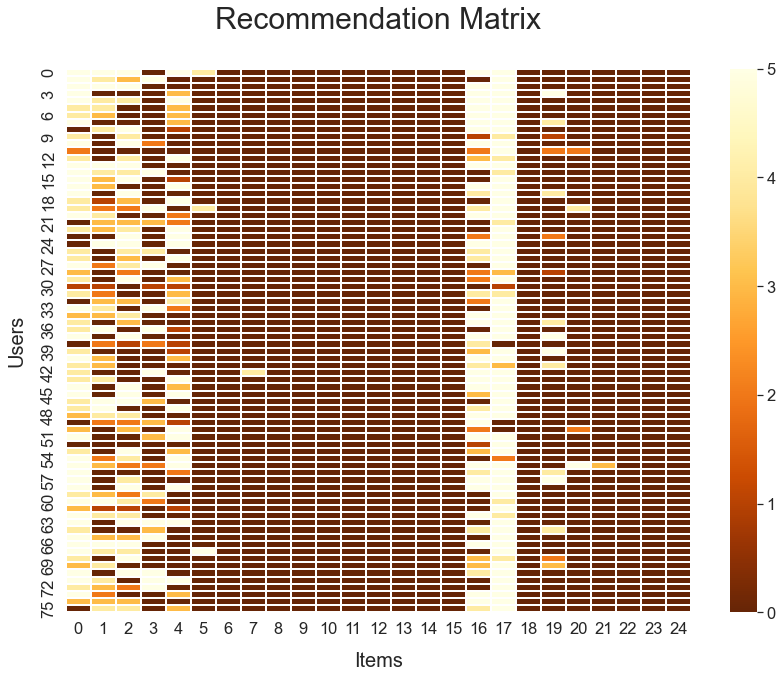

In [86]:
# Visualizing reviewmatrix as a heatmap

# Converting Nans to zeros (int)
review_heatmap = reviewmatrix.copy()
review_heatmap = review_heatmap.fillna(0)

# Graphing total distribution of unique uses
fig_dims = (14, 10)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.heatmap(review_heatmap, linewidth=0.4, cmap='YlOrBr_r')

# Annotating Graph
plt.title("Recommendation Matrix", size = 30, pad = 40)
plt.ylabel("Users", size = 20, labelpad = 15)
plt.xlabel("Items", size = 20, labelpad = 15)

plt.show()


Converting reviewmatrix (dataframe) to scipy sparse matrix. 

The ALS matrix factorization implementation requires a scipy sparse matrix as an input.

In [87]:
# x = csr_matrix(reviewmatrix)
# reviewmatrix_null = reviewmatrix.replace(0, np.nan)
# reviewmatrix_null

# Replacing Nans with Zeros
reviewmatrix_null = reviewmatrix.replace(np.nan,0)

# Converting review matrix to scipy sparse matrix
X = csr_matrix(reviewmatrix_null)

In [88]:
# Inspecing sparse matrix
sparse_array = X.toarray()

# Inspecting sparase array dtypes
print(f"The data type of the sparse array values are: {sparse_array.dtype}.")

sparse_array

The data type of the sparse array values are: int64.


array([[5, 5, 5, ..., 0, 0, 0],
       [5, 4, 3, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       ...,
       [5, 2, 0, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [0, 4, 4, ..., 0, 0, 0]], dtype=int64)

<a id='3.5'></a>

## 5. EDA

Dropping valuations = 0 and user-item duplicates

In [89]:
user_ratings.drop(user_ratings[user_ratings["valuation"] == 0].index, inplace = True)
user_ratings = user_ratings.drop_duplicates(subset=["username_id", "building_id"], keep='first')

### How many items in total have been recommended? 

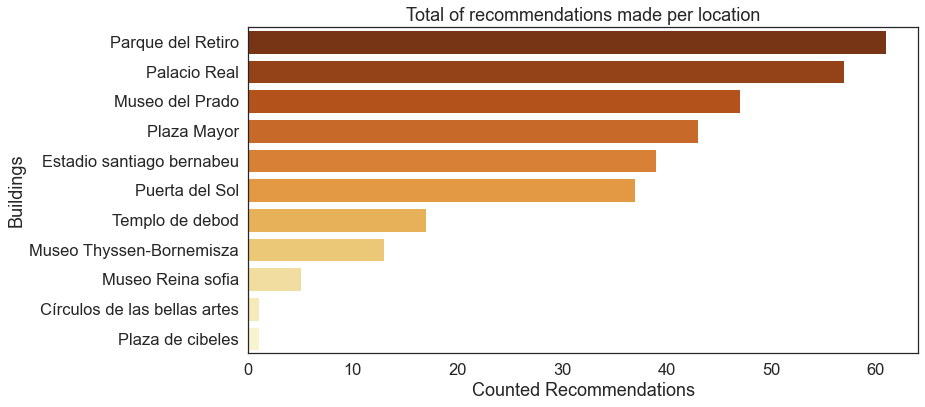

In [90]:
# let's see how many times each location was recommended and plot it
locations_count_recs = df[["building_id","username_id"]]
locations_count_recs = pd.DataFrame(locations_count_recs.groupby("building_id").count())
locations_count_recs.columns = ["count_recommendations"]
locations_count_recs = locations_count_recs.sort_values(by='count_recommendations', ascending=False)


plt.figure(figsize=(12, 6))
sns.set_style(style='white')

sns.barplot(x="count_recommendations", y=locations_count_recs.index, data=locations_count_recs, palette='YlOrBr_r').set(title="Total of recommendations made per location")
plt.xlabel('Counted Recommendations')
plt.ylabel('Buildings')
plt.show()

12 buildings have been recommended to users out of a total of 25.


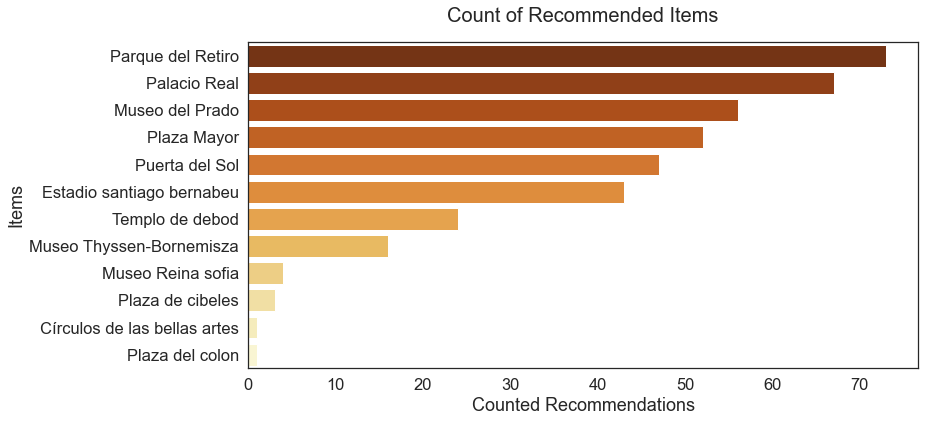

In [91]:
item_occurences = pd.DataFrame(user_ratings["building_id"].value_counts()).rename(columns = {"building_id" : "item_occurence"})
item_occurences["building_names"] = item_occurences.index

# Plotting occurences of recommended items
plt.figure(figsize=(12, 6))
sns.set_style(style='white')

sns.barplot(data = item_occurences, y = "building_names", x = "item_occurence", palette='YlOrBr_r')
#ax.tick_params(axis='x', labelrotation = 45)

# Annotating Graph
plt.title("Count of Recommended Items", size = 20, pad = 20)
plt.xlabel('Counted Recommendations')
plt.ylabel('Items')

print(f"{len(item_occurences)} buildings have been recommended to users out of a total of 25.")

plt.show()

### What items have received on average the highest recommendations? 

In [92]:
# Dataframe showing average ranking per building
avg_building_ratings = pd.pivot_table(
                       user_ratings, 
                       values = "valuation", 
                       index = "building_id",  
                       aggfunc= "sum").sort_values(by = ["valuation"], ascending = False)

rating_sum = avg_building_ratings["valuation"].values

# Adding ranking sum to dataframe
item_occurences["ranking_sum"] = rating_sum
item_occurences["ranking_avg"] = item_occurences["ranking_sum"]/item_occurences["item_occurence"]

# Average valuation
valuation_average = item_occurences["ranking_avg"].mean()

# Over and under performers
items_above_average = len(item_occurences[item_occurences["ranking_avg"] > valuation_average])
items_below_average = len(item_occurences[item_occurences["ranking_avg"] < valuation_average])


print(f"{items_above_average} received a rating above the average of {round(valuation_average,1)}.")
print(f"{items_below_average} received a rating below the average of {round(valuation_average,1)}.")

7 received a rating above the average of 3.8.
5 received a rating below the average of 3.8.


The average valuation of our recommendations for beta test 1.0 is 3.8 out of 5 stars.


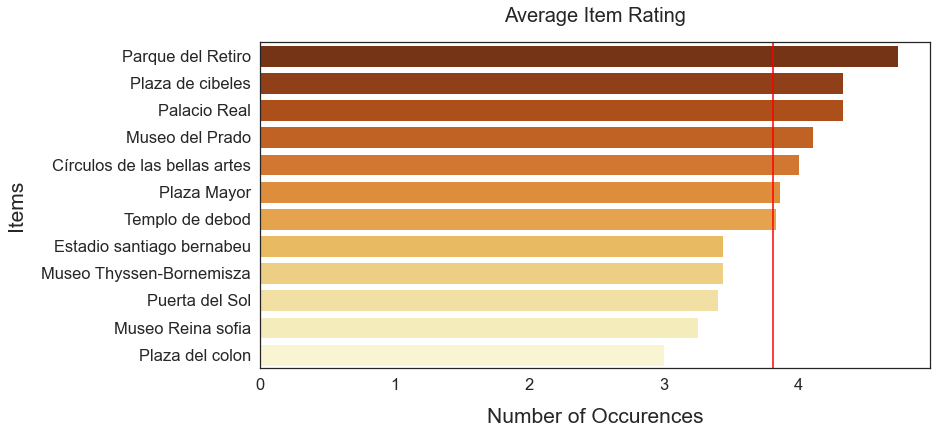

In [93]:
# Graphing average valuation of recommended items
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.set_style(style='white')


ax = sns.barplot(data = item_occurences.sort_values(by = ["ranking_avg"], ascending = False), 
                 y = "building_names", 
                 x = "ranking_avg",
                palette='YlOrBr_r')

ax.axvline(valuation_average,
          color = "red")

# Annotating Graph
plt.title("Average Item Rating", size = 20, pad = 20)
plt.xlabel("Number of Occurences", size = 21, labelpad = 15)
plt.ylabel("Items", size = 21, labelpad = 15)

# Showing Graph
print(f"The average valuation of our recommendations for beta test 1.0 is {round(valuation_average,1)} out of 5 stars.")

plt.show()

### Is there a relationship between the number of times an item is recommended and its average valuation? 

In [94]:
correlation_matrix = item_occurences[["item_occurence", "ranking_avg"]].corr()
correlation_matrix

,item_occurence,ranking_avg
item_occurence,1.00000,0.51735
ranking_avg,0.51735,1.00000


There is a medium positive correlation between the average ranking and number of occurences of items.

### Which users gave on average the highest recommendations? 

In [95]:
# Dataframe showing average ranking per building
avg_user_ratings = pd.pivot_table(
                       user_ratings, 
                       values = "valuation", 
                       index = "username_id",  
                       aggfunc= "sum").sort_values(by = ["valuation"], ascending = False)

# Adding user occurences column
user_occurences = user_ratings["username_id"].value_counts().values
avg_user_ratings["user_occurences"] = user_occurences

# Adding average user rating column
avg_user_ratings["avg_rating"] = avg_user_ratings["valuation"]/avg_user_ratings["user_occurences"]

# Average rating
avg_user_rating = avg_user_ratings["avg_rating"].mean()

# Over and under average ratings
users_above_average = len(avg_user_ratings[avg_user_ratings["avg_rating"] > avg_user_rating])
users_below_average = len(avg_user_ratings[avg_user_ratings["avg_rating"] < avg_user_rating])


print(f"{users_above_average} received a rating above the average of {round(len(avg_user_ratings),1)}.")
print(f"{users_below_average} received a rating below the average of {round(len(avg_user_ratings),1)}.")

40 received a rating above the average of 76.
36 received a rating below the average of 76.


The average rating given by users of our recommendations for beta test 1.0 is 4.0 out of 5 stars.


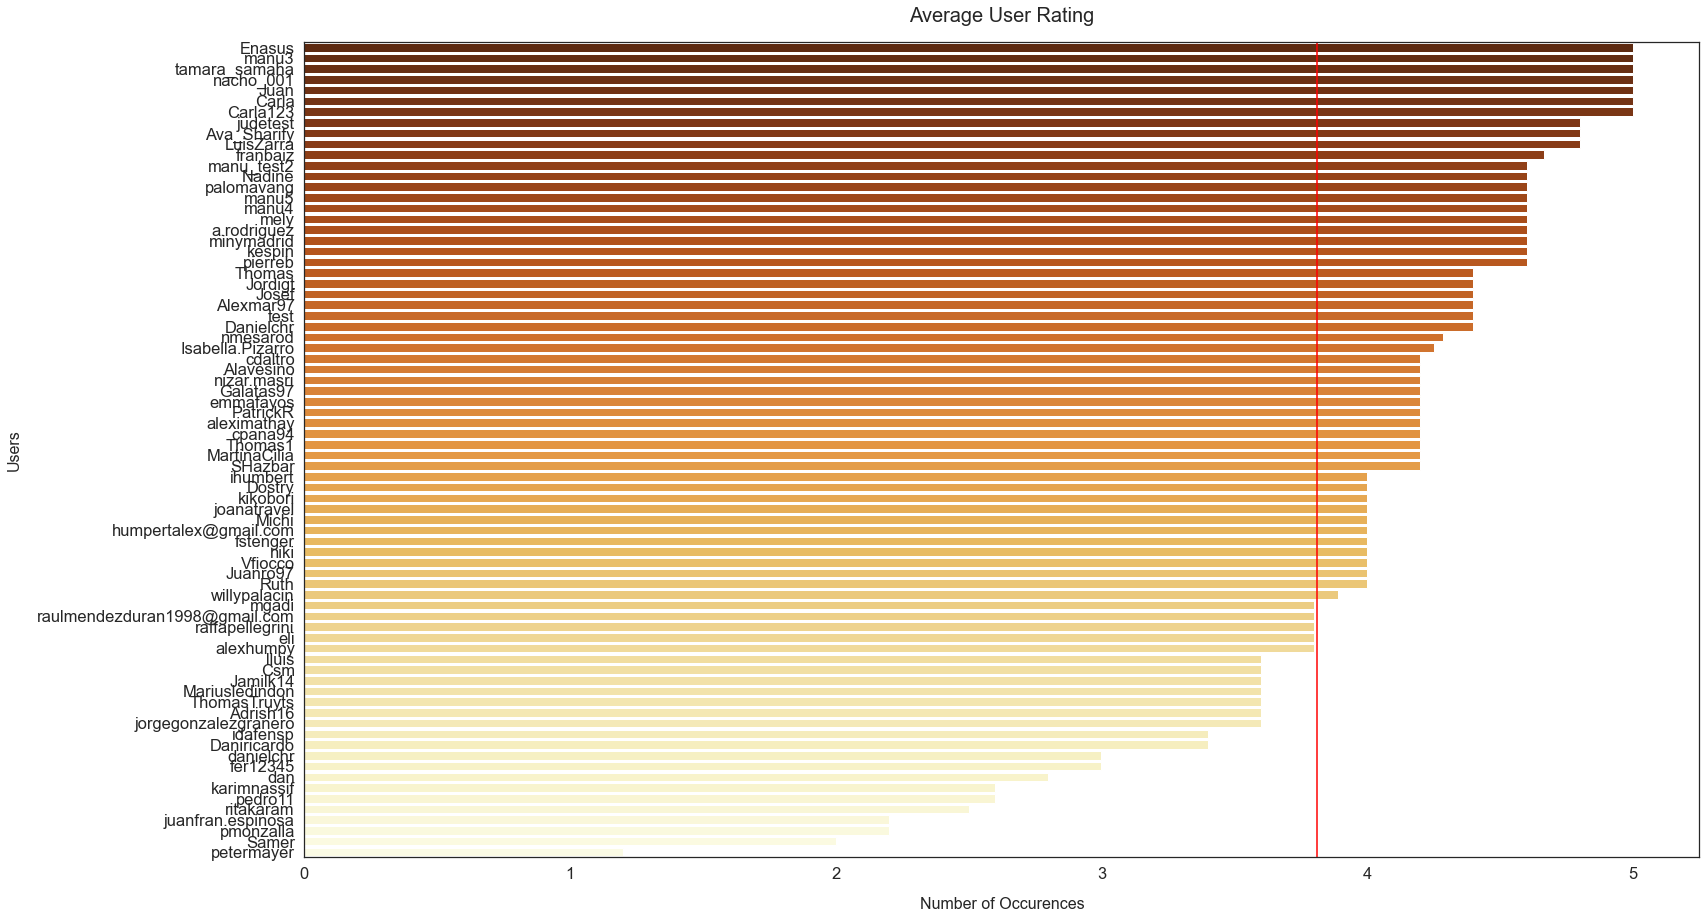

In [96]:
# Graphing average valuation of recommended items
fig_dims = (25, 15)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.barplot(data = avg_user_ratings.sort_values(by = ["avg_rating"], ascending = False), 
                 y = avg_user_ratings.index, 
                 x = "avg_rating",
                 palette='YlOrBr_r')

ax.axvline(valuation_average,
          color = "red")

# Annotating Graph
plt.title("Average User Rating", size = 20, pad = 20)
plt.xlabel("Number of Occurences", size = 16, labelpad = 15)
plt.ylabel("Users", size = 16, labelpad = 15)

# Showing Graph
print(f"The average rating given by users of our recommendations for beta test 1.0 is {round(avg_user_rating,1)} out of 5 stars.")

plt.show()

The average rating given by users of our recommendations for beta test 1.0 is 4.0 out of 5 stars.


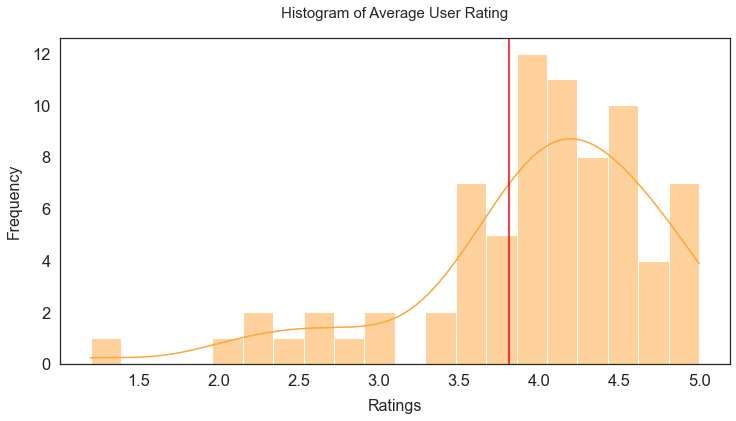

In [97]:
# Graphing average valuation of recommended items
fig_dims = (12, 6)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.histplot(data = avg_user_ratings,  
                 x = "avg_rating",
                 bins = 20,
                 kde = True,
                 color='#FFA53A')

# Annotating Graph
plt.title("Histogram of Average User Rating", size = 15, pad = 20)
plt.xlabel("Ratings", size = 16, labelpad = 10)
plt.ylabel("Frequency", size = 16, labelpad = 10)
ax.axvline(valuation_average,
          color = "red")

# Showing Graph
print(f"The average rating given by users of our recommendations for beta test 1.0 is {round(avg_user_rating,1)} out of 5 stars.")

plt.show()

<a id='3.6'></a>

## 6. Baseline ALS Matrix Factorization Model

#### Defining & Trainig Model 

In [98]:
# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20)

# Fit the model
model.fit(X)

  0%|          | 0/20 [00:00<?, ?it/s]

### 6.1 Item to Item Recommendations 

Because you like building X, we recommend the following buildings.

In [99]:
# Defining building of interest
building_of_interest = 'Museo Reina sofia'

# Identifying corresponding unique building_id
for key, value in building_mapper.items():
    if value == building_of_interest:
        building_index = key

# Printing building_id
building_index

20

In [100]:
# Printing building ids for similarly rated buildings
related = model.similar_items(building_index)
related

(array([20, 21,  5, 16,  0,  2, 19,  3,  4, 11]),
 array([1.0000001 , 0.20547467, 0.10185605, 0.08854636, 0.07649665,
        0.04409664, 0.03103773, 0.01410333, 0.00140314, 0.        ],
       dtype=float32))

Identifying building names from building ids




In [101]:
# Saving recommended buildings to a list
building_ids = related[0]

# Saving recommended building ratings to a list
building_ratings = related[1]

# Creating empty list to save building names
building_names = []

# Matchcing building ids to building names and saving to pre-defined empty list
for unique_id in building_ids:
    for key, value in building_mapper.items():
        if unique_id == key:
            building_names.append(value)

# Creating dataframe of recommended building names and predicted feedback ratings
building_to_pred_rating = dict(zip(building_names, building_ratings))
item_to_item = pd.DataFrame.from_dict(building_to_pred_rating, orient = "index").rename(columns = {0 : "pred_rating"})
item_to_item["building_id"] = building_ids

# Inspecting dataframe
item_to_item

,pred_rating,building_id
Museo Reina sofia,1.000000,20
Plaza del colon,0.205475,21
Plaza de cibeles,0.101856,5
Museo del Prado,0.088546,16
Palacio Real,0.076497,0
Plaza Mayor,0.044097,2
Museo Thyssen-Bornemisza,0.031038,19
Templo de debod,0.014103,3
Estadio santiago bernabeu,0.001403,4
Estatua del oso y el madroadroño,0.000000,11


### 6.2 User to item recommendation


Rank the following N buildings for user X.

In [102]:
# Identifying user of interest
user_of_interest = "manu3"

# Mapping username to user_id
for key, value in user_title_mapper.items(): 
    if key == user_of_interest:
        user_id = value

#visualizing user_id
user_id

0

In [103]:
building_ids

array([20, 21,  5, 16,  0,  2, 19,  3,  4, 11])

In [104]:
# Making recommendations
ranked_items = model.rank_items(userid = user_id, 
                                user_items = X.T.tocsr(),
                                selected_items = [0, 1, 2, 3, 4, 5, 6, 7,8, 9, 10, 11, 12, 13])

# Visualizing ranked items
ranked_items

(array([ 1,  2,  0,  4,  5, 11, 10,  9,  8,  6]),
 array([1.0047573, 1.0033957, 0.999977 , 0.9981862, 0.9900084, 0.       ,
        0.       , 0.       , 0.       , 0.       ], dtype=float32))

In [105]:
# Creating dataframe of recommended building names and predicted feedback ratings
name_to_pred = dict(zip(ranked_items[0], ranked_items[1]))
user_to_item = pd.DataFrame.from_dict(name_to_pred, orient = "index").rename(columns = {0 : "pred_rating"})

# Filling empty list with building_names matching recommended building_ids
building_names = []

for key, value in building_mapper.items():
    for id_ in ranked_items[0]:
        if id_ == key:
            building_names.append(value)

# Adding building names to dataframe
user_to_item["building_name"] = building_names

# Inspecing dataframe
print(f"For user {user_of_interest} with id {user_id}, we recommend the following buildings:")
user_to_item


For user manu3 with id 0, we recommend the following buildings:


,pred_rating,building_name
1,1.004757,Palacio Real
2,1.003396,Puerta del Sol
0,0.999977,Plaza Mayor
4,0.998186,Estadio santiago bernabeu
5,0.990008,Plaza de cibeles
11,0.000000,Puerta de alcala
10,0.000000,Matadero
9,0.000000,Edificio metropolis
8,0.000000,Estacion del Ferrocarril
6,0.000000,Estatua del oso y el madroadroño


### 6.3 User-to-User Recommendations

Given your feedback for monuments M, users N have similar preferences to you.

#### Identifying user of interest

In [106]:
# Identifying user of interest
user_of_interest = "manu3"

# Mapping username to user_id
for key, value in user_title_mapper.items(): 
    if key == user_of_interest:
        user_id = value

# Visualizing id
user_id

0

In [107]:
user_id

0

#### Generating Recomendations

In [108]:
# Finding similar users
model.similar_users(userid = user_id, N = 5)

(array([ 0, 67,  4, 19, 34]),
 array([1.0000001 , 0.8723352 , 0.8690856 , 0.81232893, 0.8047066 ],
       dtype=float32))

In [109]:
# Creating dataframe of users
users_to_users = dict(zip(ranked_items[0], ranked_items[1]))
user_to_users_df = pd.DataFrame.from_dict(users_to_users, orient = "index").rename(columns = {0 : "similarity_score"})

# Finding user names
users = user_ratings["username_id"].unique()

usernames = []

for key, value in user_title_mapper.items():
    for id_ in ranked_items[0]:
        if id_ == value:
            usernames.append(key)

# Inspecting results

user_to_users_df["username"] = usernames
user_to_users_df

,similarity_score,username
1,1.004757,manu3
2,1.003396,Danielchr
0,0.999977,Carla
4,0.998186,nacho_001
5,0.990008,MartinaCilia
11,0.000000,Michi
10,0.000000,fstenger
9,0.000000,dan
8,0.000000,Isabella.Pizarro
6,0.000000,karimnassif


In [110]:
users

array(['manu3', 'Danielchr', 'Carla', 'Thomas', 'nacho_001',
       'MartinaCilia', 'Michi', 'cdaltro', 'fstenger', 'dan',
       'Isabella.Pizarro', 'karimnassif', 'Dostry', 'franbaiz', 'test',
       'mgadi', 'pierreb', 'Josef', 'ThomasTruyts', 'tamara_samaha',
       'Thomas1', 'danielchr', 'ihumbert', 'raffapellegrini', 'judetest',
       'PatrickR', 'SHazbar', 'emmafayos', 'ritakaram', 'eli',
       'petermayer', 'Daniricardo', 'idafensp', 'nizar.masri', 'kikobori',
       'Galatas97', 'joanatravel', 'Carla123', 'pmonzalla', 'Jamilk14',
       'cpana94', 'lluis', 'manu4', 'manu5', 'mely', 'a.rodriguez',
       'nmesarod', 'kespin', 'Alavesino', 'pedro11', 'fer12345',
       'minymadrid', 'Samer', 'Juanro97', 'jorgegonzalezgranero',
       'Enasus', 'willypalacin', 'Nadine', 'Ava_Sharify', 'Csm',
       'Vfiocco', 'juanfran.espinosa', 'Alexmar97', 'Juan', 'Ruth',
       'aleximathay', 'LuisZarra', 'Jordigt', 'Adrish16',
       'Mariusledindon', 'manu_test2', 'palomavang',
       'r

### 6.4 EDA of users using Collaborative-Filtering Recommender based on ALS Matrix Factorization


#### Data Cleaning

Initial users and observations

In [111]:
ratings_collab = pd.read_csv("polls_seconduse.csv")

In [112]:
users = len(ratings_collab["username_id"].value_counts())

print(f"The initial number of observations is {len(ratings_collab)}")
print(f"The initial number of users is {users}")

The initial number of observations is 50
The initial number of users is 9


In [113]:
# Dropping all rows where a user rated a building twice

ratings_collab = ratings_collab.drop_duplicates(subset=["username_id", "building_id"], keep='first')

# Recalculating number of users
users = len(ratings_collab["username_id"].value_counts())

In [114]:
print("After dropping observations who rated buildings twice:")
print(f"The remaining number of observations is {len(ratings_collab)}")
print(f"The remaining number of users is {users}")

After dropping observations who rated buildings twice:
The remaining number of observations is 45
The remaining number of users is 9


Dropping records based on incomplete feedback

In [115]:
# Dropping rows with no feedback
ratings_collab.drop(ratings_collab[ratings_collab["valuation"] == 0].index, inplace = True)

# Recalculating number of users
users = len(ratings_collab["username_id"].value_counts())

In [116]:
print("After dropping observations who did not provide feedback:")
print(f"The remaining number of observations is {len(ratings_collab)}")
print(f"The remaining number of users is {users}")

After dropping observations who did not provide feedback:
The remaining number of observations is 45
The remaining number of users is 9


In [117]:
ratings_collab["username_id"].value_counts()

manu3           5
manu_test2      5
Thomas          5
palomavang      5
emmafayos       5
manu4           5
manu5           5
MartinaCilia    5
Enasus          5
Name: username_id, dtype: int64

### Investigating User ratings

In [118]:
# Dataframe showing average ranking per building
avg_user_ratings = pd.pivot_table(
                       ratings_collab, 
                       values = "valuation", 
                       index = "username_id",  
                       aggfunc= "sum").sort_values(by = ["valuation"], ascending = False)

# Adding user occurences column
user_occurences = ratings_collab["username_id"].value_counts().values
avg_user_ratings["user_occurences"] = user_occurences

# Adding average user rating column
avg_user_ratings["avg_rating"] = avg_user_ratings["valuation"]/avg_user_ratings["user_occurences"]

# Average rating
avg_user_rating = avg_user_ratings["avg_rating"].mean()

# Over and under average ratings
users_above_average = len(avg_user_ratings[avg_user_ratings["avg_rating"] > avg_user_rating])
users_below_average = len(avg_user_ratings[avg_user_ratings["avg_rating"] < avg_user_rating])


print(f"{users_above_average} users received a rating above the average of {round(avg_user_rating,2)}.")
print(f"{users_below_average} users receied a rating below the average of {round(avg_user_rating,2)}.")

7 users received a rating above the average of 4.11.
2 users receied a rating below the average of 4.11.


The average rating given by users of our recommendations for beta test 1.0 is 4.1 out of 5 stars.


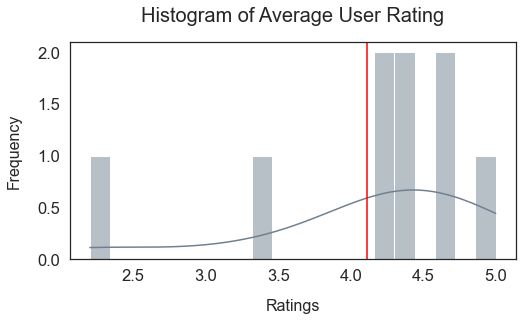

In [119]:
# Graphing average valuation of recommended items
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.histplot(data = avg_user_ratings,  
                 x = "avg_rating",
                 bins = 20,
                 kde = True,
                 color = 'slategray')


# Annotating Graph
plt.title("Histogram of Average User Rating", size = 20, pad = 20)
plt.xlabel("Ratings", size = 16, labelpad = 15)
plt.ylabel("Frequency", size = 16, labelpad = 15)
ax.axvline(avg_user_rating,
          color = "red")

# Showing Graph
print(f"The average rating given by users of our recommendations for beta test 1.0 is {round(avg_user_rating,1)} out of 5 stars.")

plt.show()

### Point of Interest Recommendations

In [120]:
item_occurences

,item_occurence,building_names,ranking_sum,ranking_avg
Parque del Retiro,73,Parque del Retiro,346,4.739726
Palacio Real,67,Palacio Real,290,4.328358
Museo del Prado,56,Museo del Prado,230,4.107143
Plaza Mayor,52,Plaza Mayor,201,3.865385
Puerta del Sol,47,Puerta del Sol,160,3.404255
Estadio santiago bernabeu,43,Estadio santiago bernabeu,148,3.441860
Templo de debod,24,Templo de debod,92,3.833333
Museo Thyssen-Bornemisza,16,Museo Thyssen-Bornemisza,55,3.437500
Museo Reina sofia,4,Museo Reina sofia,13,3.250000
Plaza de cibeles,3,Plaza de cibeles,13,4.333333


12 buildings have been recommended to users out of a total of 25.
The top 5 most recommended items represent 91.11% of all recommendations.


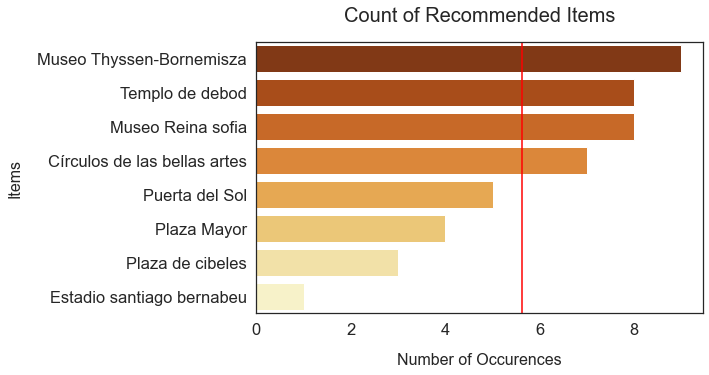

In [121]:
# Calculating item occurences
item_occurences_1 = pd.DataFrame(ratings_collab["building_id"].value_counts()).rename(columns = {"building_id" : "item_occurence"})
item_occurences_1["building_names"] = item_occurences_1.index
avg_item_occurence_1 = item_occurences_1.describe().loc["mean":"mean",:].values[0][0]

# Calculating top 5 item occurences
freq_top_5 = item_occurences_1.iloc[:6, 0:1].sum()
freq_all = item_occurences_1.iloc[:, 0:1].sum()
top_5_ratio = freq_top_5.values[0]/freq_all.values[0]

# Plotting occurences of recommended items
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.barplot(data = item_occurences_1, y = "building_names", x = "item_occurence", palette='YlOrBr_r')
ax.tick_params(axis='x')

# Annotating Graph
plt.title("Count of Recommended Items", size = 20, pad = 20)
plt.xlabel("Number of Occurences", size = 16, labelpad = 15)
plt.ylabel("Items", size = 16, labelpad = 15)
ax.axvline(avg_item_occurence_1,
          color = "red")

print(f"{len(item_occurences)} buildings have been recommended to users out of a total of 25.")
print(f"The top 5 most recommended items represent {round(top_5_ratio*100,2)}% of all recommendations.")

plt.show()

________________________________________

<a id='3.7'></a>

## 7. SVD Matrix Factorization Model

### 7.1 Preparing Utility Matrix

#### Creating Helper functions for users

In [122]:
# Dropping all rows where a user rated a building twice
rating_svd = rating_svd.drop_duplicates(subset=["username_id", "building_id"], keep='first')

In [123]:
def user_finder(username_id):
    all_users = rating_svd['username_id'].tolist()
    closest_match = process.extractOne(username_id,all_users)
    return closest_match[0]

users = rating_svd['username_id'].nunique()
users_index = list(range(users))
user_title_inv_mapper = dict(zip(users_index, rating_svd['username_id'].unique()))

def get_user_index(username_id):
    fuzzy_name = user_finder(username_id)
    user_id = user_title_mapper[fuzzy_name] #user_title_mapper
    return user_id

def get_user_title(user_idx): 
    name = user_title_inv_mapper[user_idx]
    return name 



In [124]:
# Rreplacing usernames with unique index ids
rating_svd =rating_svd.replace({"username_id": user_title_mapper})
rating_svd

,username_id,building_id,valuation
0,0,Estadio santiago bernabeu,5
1,0,Puerta del Sol,5
2,0,Parque del Retiro,5
3,0,Palacio Real,5
5,1,Parque del Retiro,5
...,...,...,...
617,75,Plaza Mayor,4
618,75,Estadio santiago bernabeu,3
619,75,Museo del Prado,4
620,55,Templo de debod,2


#### Replacing building names with unique integer IDs.

Dictionary mapping zero based index ids (keys) to building names (values).

In [125]:
#Creating a list of building ids
building_ids = list(buildings_svd["building_id"])

# Creating a list of building names
building_names = list(buildings_svd["name"])

# Creating dictionary zipping each building id to its corresponding name 
building_mapper = dict(zip(building_ids, building_names))

building_mapper

{0: 'Palacio Real',
 1: 'Puerta del Sol',
 2: 'Plaza Mayor',
 3: 'Templo de debod',
 4: 'Estadio santiago bernabeu',
 5: 'Plaza de cibeles',
 6: 'Puerta de alcala',
 7: 'Círculos de las bellas artes',
 8: 'Matadero',
 9: 'Edificio metropolis',
 10: 'Estacion del Ferrocarril',
 11: 'Estatua del oso y el madroadroño',
 12: 'Estadio Wanda Metropolitcano',
 13: 'Catedral de la Almudena',
 14: 'Plaza de Toros de las Ventas',
 15: 'Jardines de Sabatini',
 16: 'Museo del Prado',
 17: 'Parque del Retiro',
 18: 'Rosaleda del Retiro',
 19: 'Museo Thyssen-Bornemisza',
 20: 'Museo Reina sofia',
 21: 'Plaza del colon',
 22: 'Placa de la Independencia',
 23: 'Campo del Moro',
 24: 'Biblioteca nacional'}

Creating building mapper

In [126]:
# Replacing building names with building ids
rating_svd = rating_svd.replace(building_names, building_ids)

# Renaming "valuation" column to "rating"
rating_svd.rename(columns = {"valuation" : "rating"}, inplace = True)

#inspecting ratings dataframe
rating_svd.head()

,username_id,building_id,rating
0,0,4,5
1,0,1,5
2,0,17,5
3,0,0,5
5,1,17,5


#### Creating the sparse matrix of user-item feedback

In [127]:
# Creating empty review matrix with user_ids as the index and building_ids as columns
reviewmatrix = pd.DataFrame(index=np.arange(rating_svd['username_id'].nunique()), 
                            columns=np.arange(buildings_svd['building_id'].nunique()))

reviewmatrix.head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# Filling review matrix with ratings from "ratings" dataframe
for index, row in rating_svd.iterrows():
    user = row['username_id']
    building = row['building_id']
    rating = row['rating']
    reviewmatrix[building][user] = rating

# Inspecting review matrix
reviewmatrix.head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,5,5,5,NaN,5,4,NaN,NaN,NaN,NaN,...,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,4,3,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 7.2 Baseline SVD Matrix Factorization Model

#### Model Overview

What SVD does is, it takes a matrix and gives three matrices as the output -> 'U' (orthogonal), 'S'(diagonal) and 'Vt'(transpose of an orthogonal). SVD is a matrix factorization technique that takes a matrix and decomposes it to the best lower rank(takes the best features, kind of like pca). In this case U is the users feature matrix (something like how much users "like" certain features), Vt is the items vector and S is the diagonal matrix of singular values (something like weights).

#### Getting the U, S and Vt values


In [129]:
U, sigma, Vt = svd(reviewmatrix.fillna(0), full_matrices=False)

In [130]:
# Sigma value above is outputed as an array, but we need it in the form of a diagonal matrix.
sigma = np.diag(sigma)

#### Creating predictions


In [131]:
predicted = np.dot(np.dot(U, sigma), Vt)
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

In [132]:
predicted_ratings

array([[5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 4.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+00, 5.00000000e+00, 5.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.00000000e+00, 2.00000000e+00, 7.75881073e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 3.00000000e+00, 3.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.64167855e-15, 4.00000000e+00, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

#### Creating a matrix with the predicted rates

In [133]:
predicted_df = pd.DataFrame(predicted_ratings, columns= reviewmatrix.columns)
#Data frame index starts with 0 but original dataset starts with 1, so adding 1 to index
predicted_df.index = predicted_df.index

In [134]:
predicted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,5.0,5.000000e+00,5.000000e+00,4.323259e-14,5.000000e+00,4.000000e+00,1.018344e-15,1.933912e-14,-5.402513e-16,-1.225020e-16,...,-9.548698e-33,5.000000e+00,5.0,-1.296946e-49,-1.722179e-14,2.270758e-16,1.356798e-15,0.0,0.0,0.0
1,5.0,4.000000e+00,3.000000e+00,5.000000e+00,-1.761512e-14,2.120291e-15,-4.610146e-17,-3.210972e-16,4.850422e-18,1.108266e-16,...,1.053708e-32,-3.514461e-14,5.0,1.182469e-49,-1.419558e-14,5.976512e-16,-7.614453e-16,0.0,0.0,0.0
2,5.0,5.000000e+00,5.000000e+00,3.917687e-14,-2.203656e-14,5.031461e-15,-3.233095e-16,-2.630960e-15,1.245520e-16,2.301622e-17,...,2.947733e-32,5.000000e+00,5.0,-1.365858e-49,-1.771100e-14,5.701766e-16,-5.706009e-16,0.0,0.0,0.0
3,5.0,1.432607e-14,7.578856e-15,3.574122e-14,3.000000e+00,2.637551e-15,1.260311e-16,3.262354e-15,-2.604051e-16,1.912853e-16,...,1.244815e-32,5.000000e+00,5.0,6.708458e-50,5.000000e+00,1.202293e-15,6.799952e-16,0.0,0.0,0.0
4,5.0,4.000000e+00,4.000000e+00,4.132590e-14,5.000000e+00,4.048397e-15,3.235265e-16,1.375107e-15,-5.852242e-17,1.202709e-17,...,1.144962e-33,5.000000e+00,5.0,3.463036e-50,-1.805409e-14,8.679502e-16,-9.839410e-16,0.0,0.0,0.0


#### Normamizing the predicted matrix
Scaling the values from 1 to 5, as same as the original ranking scale. 

In [135]:
scaler = preprocessing.MinMaxScaler(feature_range=(1, 5))
names = predicted_df.columns
d = scaler.fit_transform(predicted_df)
scaled_df = pd.DataFrame(d, columns=names)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,5.0,5.0,5.0,1.0,5.0,4.2,4.361373,1.0,1.0,3.276827,...,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,5.0,4.2,3.4,5.0,1.0,1.0,3.292426,1.0,1.0,3.594036,...,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,5.0,5.0,5.0,1.0,1.0,1.0,3.014045,1.0,1.0,3.474658,...,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,5.0,1.0,1.0,1.0,3.4,1.0,3.465286,1.0,1.0,3.703420,...,1.0,5.0,5.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0
4,5.0,4.2,4.2,1.0,5.0,1.0,3.663617,1.0,1.0,3.459719,...,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 7.3 Model evaluation


Creating a list of the buildings that users have rated to compare their ratings with predicted rating

In [136]:
buildings_users_rated = []
for user in rating_svd['username_id'].unique():
    monuments = list(rating_svd[rating_svd["username_id"]==user]['building_id'])
    buildings_users_rated.append(monuments)
    
# buildings_users_rated

Defining a function to create a list of lists with the original rates  

In [137]:
def get_actual_user_ratings(ratings):
    actual_user_ratings = []
    
    for user in range(len(buildings_users_rated)):
        user_rating_list = []
        # Extract column values by using DataFrame.loc[] property
        user_ratings = ratings.loc[ratings['username_id'] == user, ('building_id','rating')]

        for building in buildings_users_rated[user]:

            user_rating_list.append(int(user_ratings.loc[user_ratings['building_id']==building, 'rating']))

        actual_user_ratings.append(user_rating_list)
    
    return actual_user_ratings

actual_user_ratings = get_actual_user_ratings(rating_svd)

Defining a function to create a list of lists with the predicted rates  

In [138]:
def get_predicted_user_ratings(ratings):
    predicted_user_ratings = []
    
    for user in range(len(buildings_users_rated)):
        user_rating_list = []

        for building in buildings_users_rated[user]:
            user_rating_list.append(ratings[building][user])

        predicted_user_ratings.append(user_rating_list)
    
    return predicted_user_ratings

predicted_user_ratings = get_predicted_user_ratings(predicted_df)

Defining a function to have the absolute value of the original value minus the predicted value for every monument

In [139]:
def get_accuracy(actual_user_ratings,predicted_user_ratings):

    actual_minus_predicted = [list(map(lambda actual_user_ratings, predicted_user_ratings: actual_user_ratings - predicted_user_ratings, ii, jj)) for ii, jj in zip(actual_user_ratings, predicted_user_ratings)]

    absolute_list = []

    for user in range(len(actual_minus_predicted)):
        user_abs_rating_list = []

        for building in range(len(actual_minus_predicted[user])):
                user_abs_rating_list.append(abs(actual_minus_predicted[user][building]))

        absolute_list.append(user_abs_rating_list)
        
    average_error= []
        
    for user in range(len(absolute_list)):
        # user_abs_rating_list = []
        count = 0
        total = 0

        for building in range(len(absolute_list[user])):
            count+=1 
            total+= absolute_list[user][building]
        

        average_error.append(total/count)
    
    return average_error

Model error per user in absolute value

In [140]:
model_error =  get_accuracy(actual_user_ratings,predicted_user_ratings)  
model_error

[1.738292049984531e-14,
 1.5010215292932115e-14,
 1.616484723854228e-14,
 1.4122036873231992e-14,
 1.7763568394002505e-14,
 1.4566126083082053e-14,
 1.5187850976872143e-14,
 1.3589129821411917e-14,
 1.432187701766452e-14,
 9.015010959956271e-15,
 1.7230661342182428e-14,
 5.950795411990839e-15,
 1.1901590823981678e-14,
 1.5454304502782178e-14,
 1.1368683772161604e-14,
 9.325873406851315e-15,
 1.6076029396572268e-14,
 1.2256862191861729e-14,
 8.837375276016245e-15,
 1.3433698597964394e-14,
 1.5232259897857146e-14,
 9.370282327836322e-15,
 9.14823772291129e-15,
 1.1457501614131616e-14,
 1.5631940186722205e-14,
 1.5010215292932115e-14,
 1.2967404927621828e-14,
 1.2168044349891715e-14,
 6.94999613415348e-15,
 1.2345680033831741e-14,
 2.9976021664879227e-15,
 1.2434497875801753e-14,
 1.127986593019159e-14,
 1.3677947663381929e-14,
 1.2168044349891715e-14,
 1.0391687510491465e-14,
 1.452171716209705e-14,
 1.2434497875801753e-14,
 6.572520305780927e-15,
 1.070254995738651e-14,
 1.5365486660812

averaging the error for all users

In [141]:
avg_error = sum(model_error)/len(model_error)
print('The average error is: {0}'.format(avg_error))

The average error is: 1.2488798633509925e-14


### 7.4 Recommendations

#### Creating a function to get recommendations

What the above function does is it takes a user, looks at what buildings (s)he's already rated, ignores them and returns the top 10 recommended buildings. It also returns the top building the person has rated to compare the results.

In [142]:
def svd_recommender(df_predict, user, umr, number_recomm):
    user_predicted_buildings = df_predict.loc[user, :].sort_values(ascending = False)
    original_data = umr.loc[user, :].sort_values(ascending = False)
    already_rated = reviewmatrix.loc[user, :].dropna()
    unrated = list(reviewmatrix.loc[1, pd.isnull(reviewmatrix.loc[user, :])].index)
    
    # already_rated = already_rated.replace(builder_mapper)
    d = {'building_name': list(already_rated.index), 'rating': already_rated}
    already_rated1 = pd.DataFrame(data=d)
    already_rated1 = already_rated1.replace({'building_name': building_mapper}) 
    
    recommendations = df_predict.loc[user][unrated]
    recommendations = pd.DataFrame(recommendations.sort_values(ascending = False).index[:number_recomm])
    recommendations.columns = ['building_name']
    recommendations=recommendations.replace({'building_name': building_mapper}) 

    
    return recommendations, already_rated1

#### Creating helper functions

In [143]:
def building_finder(name):
    all_building = buildings_svd['name'].tolist()
    closest_match = process.extractOne(name,all_building)
    return closest_match[0]

building_title_mapper = dict(zip(buildings_svd['name'], buildings_svd['building_id']))
building_title_inv_mapper = dict(zip(buildings_svd['building_id'], buildings_svd['name']))

def get_building_index(name):
    fuzzy_name = building_finder(name)
    building_id = building_title_mapper[fuzzy_name]
    return building_id

def get_building_title(building_idx): 
    name = building_title_inv_mapper[building_idx]
    return name 

#### Getting recommendations for a user

In [144]:
user_id = 0
n_buildings = 10
name_user = get_user_title(user_id)

In [145]:
recommend, rated = svd_recommender(scaled_df, user_id , reviewmatrix, n_buildings)

In [146]:
print('Top {1} recommendations for user {0}: {2} '.format(user_id, n_buildings,name_user ))
recommend

Top 10 recommendations for user 0: manu3 


,building_name
0,Puerta de alcala
1,Edificio metropolis
2,Círculos de las bellas artes
3,Templo de debod
4,Estacion del Ferrocarril
5,Plaza del colon
6,Museo Reina sofia
7,Museo Thyssen-Bornemisza
8,Estatua del oso y el madroadroño
9,Campo del Moro


In [147]:
print('Best rated monuments by the user {0}: {1}'.format(user_id,name_user))
rated

Best rated monuments by the user 0: manu3


,building_name,rating
0,Palacio Real,5
1,Puerta del Sol,5
2,Plaza Mayor,5
4,Estadio santiago bernabeu,5
5,Plaza de cibeles,4
16,Museo del Prado,5
17,Parque del Retiro,5
